In [36]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from utils import *

import tensorflow as tf
from tensorflow import keras

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [3]:
def stack_frames(to_be_stacked, compass):
    
    stacked_frames = deque([np.zeros((64,64), dtype=np.uint) for i in range(4)], maxlen=4)
    compass_channel = np.ones(shape=list(to_be_stacked[0].shape[:-1]) + [1], dtype=to_be_stacked.dtype) * compass

    if len(to_be_stacked) != 4:
        for x in range(4-len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[0].reshape(64,64,3), "RGB").convert("L")))
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    else:
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    
    return stacked_frames

In [4]:
def stack_rgb_frames(to_be_stacked, compass):
    
    stacked_frames = deque([np.zeros((64, 64, 3), dtype=np.float32) for i in range(4)], maxlen=5)
    compass_channel = np.ones(shape=(64,64,3), dtype=to_be_stacked.dtype) * compass
    
    if len(to_be_stacked) != 4:
        for x in range(4-len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[0].reshape(64,64,3), "RGB")))
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB")))
            
        #stacked_frames.append(compass_channel)
    else:
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB")))
    
    stacked_frames.append(compass_channel)
    
    return np.asarray(stacked_frames)
    

In [5]:
path = "C:\\Users\\Robin\\Desktop\\deep_learning\\MineRLNavigateDense-v0\\"

def generate_random_video(path, batch_size=1):
    frame_shape = 64*64*3
    
    videos = list(os.listdir(path))
    
    random_video_num = np.random.randint(low=4, high=len(videos)-4)
    rand_vid = os.path.join(path+videos[random_video_num])
    
    vid_labels = np.load(rand_vid+"\\rendered.npz", allow_pickle=True)
    vid_labels = [vid_labels[x] for x in vid_labels.keys()]
    
    rewards = np.array(vid_labels[0])
    compass_angle = np.array(vid_labels[1])/180.
    
    camera_x = np.array([x[0] for x in vid_labels[11]])/180.
    camera_y = np.array([x[1] for x in vid_labels[11]])/180.
    place = vid_labels[-1]
    vid_labels = vid_labels[:11]
    vid_labels.append(place) 
    vid_labels.append(camera_x)
    vid_labels.append(camera_y)
    vid_labels = vid_labels[3:]
    
    for i in range(len(vid_labels[-3])):
        if vid_labels[-3][i] == "none":
            vid_labels[-3][i] = 0
        else:
            vid_labels[-3][i] = 1
    
    actions = []
    
    for i in range(len(vid_labels[0])):
        action_cluster = []
        for x in range(11):
            element = vid_labels[x][i]
            if x == 9 or x == 10:
                if float(element) > 0:
                    action_cluster.append(1)
                    action_cluster.append(0)
                elif float(element) < 0:
                    action_cluster.append(0)
                    action_cluster.append(1)
                else:
                    action_cluster.append(0)
                    action_cluster.append(0)
            else:
                action_cluster.append(element)
        actions.append(action_cluster)
    
    load_vid = np.load(rand_vid+"\\NDTRAIN.npy", allow_pickle=True)[0]
    
    frames = int(load_vid.shape[0]/frame_shape)
    
    reshaped_vid = load_vid.reshape(frames, 64, 64, 3)[-len(vid_labels[0]):]
    plt.imshow(reshaped_vid[0].astype(np.uint8))
    
    return np.array(reshaped_vid).astype(np.float32)/255., actions, compass_angle, rewards

#generate_random_video(path)

In [6]:
def build_model():
    dqn = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, input_shape=[64, 64, 5]),
        keras.layers.Conv2D(32, kernel_size=3, strides=1),
        keras.layers.Flatten(),
        keras.layers.Dense(13)
    ])

    return dqn

In [7]:
def build_dqrn_model():
    dqn = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=8, strides=4, padding="same", input_shape=[64, 64, 5]),
        keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="same"),
        keras.layers.Flatten(),
        keras.layers.Reshape((1, 4096)),
        keras.layers.LSTM(512, activation="relu"),
        keras.layers.Dense(128),
        keras.layers.Dense(13, activation="sigmoid")
        ])
    
    return dqn

In [31]:
def build_action_model():
    dqn = keras.models.Sequential([
        keras.layers.Input(shape=(13, 2)),
        keras.layers.Reshape((26,)),
        keras.layers.Dense(20),
        keras.layers.Dense(13, activation="sigmoid"),
        keras.layers.Reshape((13,))
    ])

    return dqn

model = build_action_model()

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 26)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                540       
_________________________________________________________________
dense_21 (Dense)             (None, 13)                273       
_________________________________________________________________
reshape_19 (Reshape)         (None, 13)                0         
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


In [21]:
'''class action_model(keras.Model):
    def __init__(self):
        super(action_model, self).__init__()
        
    def call(self, state):
        x = keras.layers.Flatten()(state)
        x = keras.layers.Reshape((1, 3200))(x)
        x = keras.layers.GRU(20, return_sequences=True)(x)
        x = keras.layers.Dense(13, activation="sigmoid")(x)
        A = keras.layers.Reshape((13,))(x)
        Q = keras.layers.Dense(13, activation="relu")(x)
        
        return A'''

'class action_model(keras.Model):\n    def __init__(self):\n        super(action_model, self).__init__()\n        \n    def call(self, state):\n        x = keras.layers.Flatten()(state)\n        x = keras.layers.Reshape((1, 3200))(x)\n        x = keras.layers.GRU(20, return_sequences=True)(x)\n        x = keras.layers.Dense(13, activation="sigmoid")(x)\n        A = keras.layers.Reshape((13,))(x)\n        Q = keras.layers.Dense(13, activation="relu")(x)\n        \n        return A'

In [62]:
per = PER(20000)
encoder = keras.models.load_model("CNN_enc.h5")

q_model = build_action_model()
#q_model.build(input_shape=(1, 8, 8, 50))
q_model.summary()

target_model = keras.models.clone_model(q_model)
target_model.set_weights(q_model.get_weights())

LOSS_FN = keras.losses.mean_squared_error
OPTIMIZER = keras.optimizers.Adam(lr=1e-3)
chkpt_dir = "C:\\Users\\Robin\\Desktop\\deep_learning\\DQFD\\chkpts"

BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.95


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 3200)              0         
_________________________________________________________________
reshape_20 (Reshape)         (None, 1, 3200)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 1, 20)             193320    
_________________________________________________________________
dense_10 (Dense)             (None, 1, 13)             273       
_________________________________________________________________
reshape_21 (Reshape)         (None, 13)                0         
Total params: 193,593
Trainable params: 193,593
Non-trainable params: 0
_________________________________________________________________


0


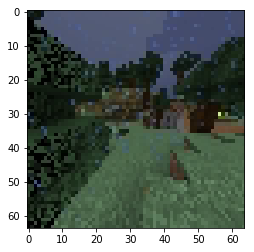

0.038311479999999974
[[-0.68614817 -0.55245155  1.6237705  ...  0.67917806  0.07817794
   0.03831148]]
(1, 3201)


ValueError: Found input variables with inconsistent numbers of samples: [1, 13]

In [77]:
autoencoder = keras.models.load_model("CNN_enc.h5")
encoder, decoder = autoencoder.layers
encoder.trainable = False

def get_data():
    video, actions, compass_angle, rewards = generate_random_video(path)
    batch = np.random.randint(video.shape[0])
    plt.imshow(video[batch])
    plt.show()
    
    print(compass_angle[batch])
        
    state = encoder.predict(np.array(video[batch]).reshape(1, 64, 64, 3))
    state = state.reshape(1, -1)
    '''X = state.reshape(-1, 1)
    k_state = KMeans(n_clusters=13).fit(X)
    clustered_state = k_state.cluster_centers_
    state = np.array(clustered_state).reshape(13, 1)'''
    
    actions = np.array(actions[batch]).reshape(1, -1)
    rewards = np.array(rewards[batch])
    
    compass = np.ones(shape=list(state.shape[:-1]) + [1], dtype=state.dtype) * compass_angle[batch]
    
    obs = np.concatenate([state, compass], axis=-1)
    
    print(obs)
    print(obs.shape)
    
    return obs, actions.astype(np.uint8)

svm = Pipeline([
        ("SVM", SVC(kernel="rbf", gamma=5, C=0.001))
    ])

for x in range(20):
    print(x)
    test_x, test_y = get_data()
    test_y = test_y.reshape(-1)
    
    svm.fit(test_x, test_y)
    
test_x, test_y = get_data()
print(svm.predict(test_x))
print(test_y)

print(svm.score(test_x, test_y))
'''
model = build_action_model()
model.compile(loss="binary_crossentropy", optimizer="adam")
loss_fn = keras.losses.binary_crossentropy

for epoch in range(100):
    print("epoch: ", epoch)
    
    random_diff, actual_actions = get_data()
    print("actual actions: ", actual_actions)
    
    model.train_on_batch(random_diff, actual_actions)
    
    print(loss_fn(actual_actions, model.predict(random_diff)))
    print("predictions: ", np.round(model.predict(random_diff)))'''

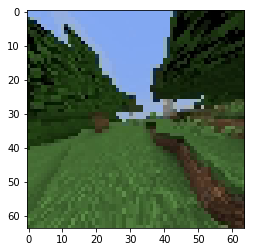

0.008545398800000076
[[ 0.49091995  0.0085454 ]
 [-1.2771424   0.0085454 ]
 [ 1.4503192   0.0085454 ]
 [-2.775107    0.0085454 ]
 [ 3.086416    0.0085454 ]
 [ 0.08264035  0.0085454 ]
 [-0.34234172  0.0085454 ]
 [ 0.94794655  0.0085454 ]
 [-1.899178    0.0085454 ]
 [ 2.190187    0.0085454 ]
 [ 4.5396543   0.0085454 ]
 [-0.76977444  0.0085454 ]
 [-3.8839364   0.0085454 ]]
(13, 2)
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 1 0 0 0 1 1 0]
0.6153846153846154


In [62]:
test_x, test_y = get_data()
print(svm.predict(test_x))
print(test_y)

print(svm.score(test_x, test_y))

In [74]:
per = PER(20000)
encoder = keras.models.load_model("CNN_enc.h5")

q_model = model
#q_model.build(input_shape=(1, 8, 8, 50))
q_model.summary()

target_model = keras.models.clone_model(q_model)
target_model.set_weights(q_model.get_weights())

LOSS_FN = keras.losses.mean_squared_error
OPTIMIZER = keras.optimizers.Adam(lr=1e-3)
chkpt_dir = "C:\\Users\\Robin\\Desktop\\deep_learning\\DQFD\\chkpts"

BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.95

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 3200)           0         
_________________________________________________________________
gru (GRU)                    (None, 1, 20)             193320    
_________________________________________________________________
dense (Dense)                (None, 1, 13)             273       
_________________________________________________________________
reshape_1 (Reshape)          (None, 13)                0         
Total params: 193,593
Trainable params: 193,593
Non-trainable params: 0
_________________________________________________________________


In [75]:
def simulate(target_model, q_model, epoch, tau):
    autoencoder = keras.models.load_model("CNN_enc.h5")
    encoder, decoder = autoencoder.layers
    encoder.trainable = False
    
    video, actions, compass_angle, rewards = generate_random_video(path)
    batch = np.random.randint(video.shape[0])
    state = encoder.predict(np.array(video[batch]).reshape(1, 64, 64, 3))
    n_state = encoder.predict(np.array(video[batch+1]).reshape(1, 64, 64, 3))
    print("State shape: ", state.shape)
    actions = np.array(actions[batch])
    rewards = np.array(rewards[batch])

    '''frames = stack_frames(state, compass_angle[batch])
    n_frames = stack_frames(n_state, compass_angle[batch+1])
    print(frames.shape)'''
    
    per.store([state, actions, rewards, n_state, 0])

In [76]:
def training_step(target_model, q_model, epoch, tau):
    tree_idx, experiences, ISWeights_mb = per.sample(BATCH_SIZE)
    print(np.array(experiences).shape)
    xp = experiences
    
    states, actions, rewards, n_states, dones = np.array([i[0][0] for i in xp]), np.array([i[0][1] for i in xp]), np.array([i[0][2] for i in xp]), np.array([i[0][3] for i in xp]), np.array([i[0][4] for i in xp])
    next_Q_values = target_model.predict(n_states)
    print(next_Q_values.shape)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    print(max_next_Q_values)
    target_Q_values = (rewards +
                      (1 - dones) * DISCOUNT_FACTOR * max_next_Q_values)
    
    mask = actions
    
    with tf.GradientTape() as tape:
        all_Q_values = q_model(states)
        
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        print(Q_values.shape)
        loss = tf.reduce_mean(LOSS_FN(target_Q_values, Q_values))
        print("LOSS: ", loss)
        
    grads = tape.gradient(loss, q_model.trainable_variables)
    OPTIMIZER.apply_gradients(zip(grads, q_model.trainable_variables))
    q_model.save(chkpt_dir+"\\CNN_MLP\\q_model.h5")

    abs_error = tf.abs(target_Q_values - Q_values)

    per.batch_update(tree_idx, abs_error)

In [77]:
def ddqn_training_step(target_model, q_model, epoch, tau):
    tree_idx, experiences, ISWeights_mb = per.sample(BATCH_SIZE)
    print(np.array(experiences).shape)
    xp = experiences
    
    states, actions, rewards, n_states, dones = np.array([i[0][0] for i in xp]), np.array([i[0][1] for i in xp]), np.array([i[0][2] for i in xp]), np.array([i[0][3] for i in xp]), np.array([i[0][4] for i in xp])
    next_Q_values = q_model.predict(n_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, 13).numpy()
    next_best_Q_values = (target_model.predict(n_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                      (1 - dones) * DISCOUNT_FACTOR * next_best_Q_values)
    mask = actions
    with tf.GradientTape() as tape:
        all_Q_values = q_model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(LOSS_FN(target_Q_values, Q_values))
        print("LOSS: ", loss)
    grads = tape.gradient(loss, q_model.trainable_variables)
    OPTIMIZER.apply_gradients(zip(grads, q_model.trainable_variables))
    
    abs_error = tf.abs(target_Q_values - Q_values)
    per.batch_update(tree_idx, abs_error)
    

0
State shape:  (1, 8, 8, 50)
1
State shape:  (1, 8, 8, 50)
2
State shape:  (1, 8, 8, 50)
3
State shape:  (1, 8, 8, 50)
4
State shape:  (1, 8, 8, 50)
5
State shape:  (1, 8, 8, 50)
6
State shape:  (1, 8, 8, 50)
7
State shape:  (1, 8, 8, 50)
8
State shape:  (1, 8, 8, 50)
9
State shape:  (1, 8, 8, 50)
10


State shape:  (1, 8, 8, 50)
11
State shape:  (1, 8, 8, 50)
12
State shape:  (1, 8, 8, 50)
13
State shape:  (1, 8, 8, 50)
14
State shape:  (1, 8, 8, 50)
15
State shape:  (1, 8, 8, 50)
16
State shape:  (1, 8, 8, 50)
17
State shape:  (1, 8, 8, 50)
18
State shape:  (1, 8, 8, 50)
19
State shape:  (1, 8, 8, 50)
20
State shape:  (1, 8, 8, 50)
21


State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.8105724  0.8105724  0.7626854  0.7626854  0.6939825
 0.8072133  0.8072133  0.75566965 0.6988007  0.77764547 0.6873543
 0.6873543  0.6873543  0.7573793  0.7573793  0.67429715 0.67429715
 0.72408575 0.6714931  0.7232206  0.7232206  0.5735731  0.5735731
 0.6506545  0.71126276 0.8619217  0.8619217  0.8437281  0.7740573
 0.77996784 0.77996784]
(32, 1)
LOSS:  tf.Tensor(0.7395576, shape=(), dtype=float32)
[[1.         0.8406232  0.8406232  ... 1.         0.95677733 0.95677733]
 [0.6097247  0.18633346 0.18633346 ... 0.51270247 0.42585245 0.42585245]
 [0.6097247  0.18633346 0.18633346 ... 0.51270247 0.42585245 0.42585245]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         0.7635823  0.7635823  ... 0.94221073 0.8865544  0.8865544 ]
 [1.         0.7635823  0.7635823  ... 0.94221073 0.8865544  0.8865544 ]]
19999 [1.         0.8406232  0.8406232  1.         1.         1.
 1.         1.         0.99

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.7127012  0.8105724  0.7626854  0.8072133  0.8072133
 0.75566965 0.75566965 0.6988007  0.6988007  0.77764547 0.6873543
 0.6873543  0.70847523 0.70847523 0.67429715 0.67429715 0.67429715
 0.72408575 0.6714931  0.6714931  0.7232206  0.6506545  0.6506545
 0.71126276 0.71126276 0.8437281  0.7740573  0.77996784 0.77996784
 0.7921204  0.7921204 ]
(32, 1)
LOSS:  tf.Tensor(0.4976486, shape=(), dtype=float32)
[[0.9362142  0.9362142  0.6741658  ... 0.8063703  0.81790173 0.81790173]
 [0.9362142  0.9362142  0.6741658  ... 0.8063703  0.81790173 0.81790173]
 [0.41185337 0.41185337 0.34492767 ... 0.12345757 0.16037397 0.16037397]
 ...
 [0.731432   0.731432   0.39888516 ... 0.57396054 0.588374   0.588374  ]
 [0.9001685  0.9001685  0.6288543  ... 0.76640135 0.77832526 0.77832526]
 [0.9001685  0.9001685  0.6288543  ... 0.76640135 0.77832526 0.77832526]]
19999 [0.9362142  0.9362142  0.6741658  0.886016   0.875973   0.875973
 0.8459244  0.845924

20013 [0.64288056 0.64288056 0.25305024 0.5772895  0.5638731  0.5638731
 0.52303636 0.52303636 0.55718726 0.55718726 0.58902156 0.6669197
 0.6669197  0.31014198 0.31014198 0.6599914  0.6599914  0.6599914
 0.5370852  0.5165545  0.5165545  0.47565502 0.53957903 0.53957903
 0.55199856 0.55199856 0.42771503 0.5497066  0.46739367 0.46739367
 0.48386738 0.48386738]
20015 [0.69506496 0.69506496 0.3426216  0.63308054 0.6204786  0.6204786
 0.58230925 0.58230925 0.6142095  0.6142095  0.6441232  0.71791905
 0.71791905 0.21234502 0.21234502 0.71132547 0.71132547 0.71132547
 0.5954066  0.57627916 0.57627916 0.53843474 0.59773535 0.59773535
 0.60934937 0.60934937 0.49459684 0.607204   0.53083706 0.53083706
 0.5460037  0.5460037 ]
20015 [0.69506496 0.69506496 0.3426216  0.63308054 0.6204786  0.6204786
 0.58230925 0.58230925 0.6142095  0.6142095  0.6441232  0.71791905
 0.71791905 0.21234502 0.21234502 0.71132547 0.71132547 0.71132547
 0.5954066  0.57627916 0.57627916 0.53843474 0.59773535 0.59773535
 

 0.8010347  0.8010347 ]
20011 [0.81741035 0.81741035 0.52066535 0.7621942  0.7586776  0.7510789
 0.7176696  0.7176696  0.7455645  0.8379749  0.8379749  0.8379749
 0.27121037 0.27121037 0.83203137 0.83203137 0.7290881  0.7290881
 0.7290881  0.67979836 0.67979836 0.73112357 0.74129665 0.74129665
 0.6257673  0.7394147  0.7394147  0.67330426 0.6862875  0.6862875
 0.8010347  0.8010347 ]
20013 [0.53676707 0.53676707 0.15161514 0.46179146 0.45687014 0.44616622
 0.39782488 0.39782488 0.43833593 0.56376463 0.56376463 0.56376463
 0.45224026 0.45224026 0.55600625 0.55600625 0.41460103 0.41460103
 0.41460103 0.33983007 0.33983007 0.41756213 0.4322379  0.4322379
 0.24774955 0.42953813 0.42953813 0.32944667 0.3500627  0.3500627
 0.5149395  0.5149395 ]
20013 [0.53676707 0.53676707 0.15161514 0.46179146 0.45687014 0.44616622
 0.39782488 0.39782488 0.43833593 0.56376463 0.56376463 0.56376463
 0.45224026 0.45224026 0.55600625 0.55600625 0.41460103 0.41460103
 0.41460103 0.33983007 0.33983007 0.41756213 

 0.7937876  0.7937876 ]
20010 [1.         1.         0.98731333 0.98435557 0.9779754  0.9501093
 0.9501093  0.9501093  0.9955494  1.         0.6247725  0.6247725
 0.9425663  1.         1.         1.         0.9595985  0.9457668
 0.91891176 0.9612938  0.9697845  0.8752006  0.88872427 0.96821165
 0.91360646 0.91360646 0.9242263  1.         1.         1.
 0.7937876  0.7937876 ]
20011 [0.7532742  0.7532742  0.69476134 0.6910197  0.6829282  0.6472366
 0.6472366  0.6472366  0.7051489  0.7749642  0.10305063 0.10305063
 0.6374704  0.76870066 0.76870066 0.76870066 0.6594572  0.64162004
 0.60652363 0.66163313 0.6724976  0.54787105 0.566242   0.6704891
 0.5995118  0.5995118  0.6135208  0.7359646  0.7359646  0.7359646
 0.4316818  0.4316818 ]
20012 [0.23263277 0.23263277 0.34122267 0.34718785 0.35978904 0.4111405
 0.4111405  0.4111405  0.32416683 0.18074392 0.7996841  0.7996841
 0.4241533  0.19676176 0.19676176 0.19676176 0.39426705 0.4186733
 0.4629272  0.39118966 0.37547117 0.52787435 0.508597   

 0.24608326 0.24608326]
20004 [0.93657    0.67460865 0.8863851  0.88320625 0.87634486 0.846305
 0.846305   0.87137216 0.95538247 0.95538247 0.48127124 0.48127124
 0.8381526  0.94993895 0.94993895 0.85654795 0.8416128  0.8416128
 0.8125247  0.8675273  0.8675273  0.7648964  0.865833   0.865833
 0.80676335 0.80676335 0.818291   0.92163515 0.92163515 0.77526665
 0.77526665 0.77526665]
20004 [0.93657    0.67460865 0.8863851  0.88320625 0.87634486 0.846305
 0.846305   0.87137216 0.95538247 0.95538247 0.48127124 0.48127124
 0.8381526  0.94993895 0.94993895 0.85654795 0.8416128  0.8416128
 0.8125247  0.8675273  0.8675273  0.7648964  0.865833   0.865833
 0.80676335 0.80676335 0.818291   0.92163515 0.92163515 0.77526665
 0.77526665 0.77526665]
20005 [0.37625143 0.3824843  0.27666107 0.2697023  0.25431624 0.17882511
 0.17882511 0.24281877 0.41003406 0.41003406 0.5983545  0.5983545
 0.15482874 0.40040958 0.40040958 0.20641819 0.16527818 0.16527818
 0.07364467 0.23370546 0.23370546 0.22086306 0.229

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.7626854  0.7626854  0.6939825  0.8072133  0.75566965
 0.6988007  0.77764547 0.77764547 0.6873543  0.70847523 0.7573793
 0.67429715 0.67429715 0.67429715 0.72408575 0.7232206  0.7232206
 0.6506545  0.8619217  0.8619217  0.8437281  0.7740573  0.7740573
 0.77996784 0.7921204  0.66687584 0.66687584 0.66687584 0.7375975
 0.80427414 0.80427414]
(32, 1)
LOSS:  tf.Tensor(0.1677472, shape=(), dtype=float32)
[[0.36769316 0.26610073 0.26610073 ... 0.20891581 0.16912104 0.16912104]
 [0.6348671  0.56867284 0.56867284 ... 0.4104492  0.43373322 0.43373322]
 [0.6348671  0.56867284 0.56867284 ... 0.4104492  0.43373322 0.43373322]
 ...
 [0.41137537 0.31898078 0.31898078 ... 0.13317318 0.07348925 0.07348925]
 [0.40093538 0.30655423 0.30655423 ... 0.15405549 0.10246394 0.10246394]
 [0.40093538 0.30655423 0.30655423 ... 0.15405549 0.10246394 0.10246394]]
19999 [0.36769316 0.26610073 0.26610073 0.25895494 0.2431238  0.1644931
 0.2312616  0.285430

20022 [0.8127742  0.75733566 0.75733566 0.75380397 0.74617225 0.7126109
 0.74063355 0.7671493  0.7671493  0.83341527 0.2614374  0.7034585
 0.8274499  0.8274499  0.8274499  0.72408277 0.6745524  0.6745524
 0.7261275  0.6202213  0.6202213  0.6371687  0.7344563  0.7344563
 0.66802436 0.68107486 0.7963353  0.7963353  0.7963353  0.63212514
 0.6497494  0.6497494 ]
20024 [0.41137537 0.31898078 0.31898078 0.31266338 0.29878154 0.232976
 0.288493   0.33621314 0.33621314 0.44332963 0.57137275 0.21320866
 0.43420216 0.43420216 0.43420216 0.25649542 0.14169258 0.14169258
 0.26056206 0.16422707 0.16422707 0.11833199 0.27678427 0.27678427
 0.12238768 0.15947624 0.38510317 0.38510317 0.38510317 0.13317318
 0.07348925 0.07348925]
20025 [0.40093538 0.30655423 0.30655423 0.30006427 0.28578085 0.21750882
 0.27517292 0.32422844 0.32422844 0.4334076  0.5796482  0.19673766
 0.42413884 0.42413884 0.42413884 0.24203895 0.11943958 0.11943958
 0.24626371 0.18263969 0.18263969 0.14070499 0.26307538 0.26307538
 0

20011 [0.39961255 0.39961255 0.6721903  0.66008985 0.62354064 0.62354064
 0.6540761  0.6828062  0.7540175  0.7540175  0.11332257 0.61352533
 0.7476376  0.7476376  0.636064   0.6177816  0.581743   0.62249714
 0.6494168  0.6494168  0.52128226 0.5402549  0.64736086 0.64736086
 0.57453144 0.58893555 0.71426624 0.40025175 0.53462017 0.53462017
 0.6582297  0.6582297 ]
20012 [0.48023954 0.48023954 0.10800899 0.06639375 0.17778099 0.17778099
 0.09115119 0.14088312 0.29851916 0.29851916 0.67378515 0.19987382
 0.2865594  0.2865594  0.14684746 0.19072296 0.259992   0.18017781
 0.10748652 0.10748652 0.34981185 0.32412627 0.11416212 0.11416212
 0.27209133 0.24743363 0.21876015 0.47967353 0.3319571  0.3319571
 0.0746487  0.0746487 ]
20013 [0.4439058  0.4439058  0.18614914 0.15620305 0.09568634 0.09568634
 0.13996245 0.21024211 0.34478405 0.34478405 0.64512295 0.12711343
 0.33395156 0.33395156 0.08149274 0.11450796 0.20230433 0.09928016
 0.12653567 0.12653567 0.30404666 0.27564663 0.12032273 0.120322

20006 [0.2625472  0.6480311  0.3648341  0.38262305 0.38262305 0.43211544
 0.39118338 0.34855217 0.34855217 0.8132958  0.8132958  0.44471395
 0.22980644 0.22980644 0.4158109  0.43940595 0.4823641  0.41284144
 0.41284144 0.5457299  0.52688813 0.52688813 0.40053666 0.40053666
 0.490456   0.47413442 0.29584086 0.6475677  0.51238084 0.38529003
 0.46715534 0.46715534]
20008 [0.6827616  0.3226302  0.61997336 0.6071914  0.6071914  0.56843626
 0.6008304  0.6311689  0.6311689  0.23826717 0.23826717 0.55777407
 0.6992131  0.6992131  0.5817418  0.5623076  0.52380145 0.58410686
 0.58410686 0.45847893 0.47908926 0.47908926 0.59372026 0.59372026
 0.5160612  0.53150904 0.664254   0.32336724 0.49424458 0.60522443
 0.53791887 0.53791887]
20008 [0.6827616  0.3226302  0.61997336 0.6071914  0.6071914  0.56843626
 0.6008304  0.6311689  0.6311689  0.23826717 0.23826717 0.55777407
 0.6992131  0.6992131  0.5817418  0.5623076  0.52380145 0.58410686
 0.58410686 0.45847893 0.47908926 0.47908926 0.59372026 0.59372

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.8105724  0.7626854  0.6939825  0.75566965 0.75566965
 0.77764547 0.77764547 0.6873543  0.6873543  0.7573793  0.7573793
 0.67429715 0.72408575 0.6714931  0.7232206  0.5735731  0.71126276
 0.8619217  0.8437281  0.8437281  0.7740573  0.7740573  0.7921204
 0.66687584 0.81161666 0.7375975  0.68210447 0.80915123 0.80915123
 0.6500348  0.6500348 ]
(32, 1)
LOSS:  tf.Tensor(0.13555205, shape=(), dtype=float32)
[[0.18771885 0.51984257 0.1385202  ... 0.29680398 0.10855602 0.10855602]
 [0.3602257  0.7061781  0.44666663 ... 0.5380892  0.4338304  0.4338304 ]
 [0.5903133  0.14005835 0.5204816  ... 0.42664942 0.5318791  0.5318791 ]
 ...
 [0.9251611  0.66036767 0.8745449  ... 0.8106615  0.8826428  0.8826428 ]
 [0.58211046 0.11752284 0.5115507  ... 0.41642958 0.52307814 0.52307814]
 [0.58211046 0.11752284 0.5115507  ... 0.41642958 0.52307814 0.52307814]]
19999 [0.18771885 0.51984257 0.1385202  0.14919193 0.24784273 0.24784273
 0.10517914 0.10

20028 [0.58211046 0.11752284 0.5115507  0.5069566  0.45228657 0.45228657
 0.52424866 0.52424866 0.6077393  0.6077393  0.43983242 0.43983242
 0.6003639  0.46772784 0.44513705 0.39960438 0.45099345 0.48404324
 0.31913382 0.34506983 0.34506983 0.48154062 0.48154062 0.40881065
 0.56146824 0.1189631  0.3374425  0.49473357 0.41642958 0.41642958
 0.52307814 0.52307814]
20028 [0.58211046 0.11752284 0.5115507  0.5069566  0.45228657 0.45228657
 0.52424866 0.52424866 0.6077393  0.6077393  0.43983242 0.43983242
 0.6003639  0.46772784 0.44513705 0.39960438 0.45099345 0.48404324
 0.31913382 0.34506983 0.34506983 0.48154062 0.48154062 0.40881065
 0.56146824 0.1189631  0.3374425  0.49473357 0.41642958 0.41642958
 0.52307814 0.52307814]
30
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.8105724  0.7626854  0.6939825  0.75566965 0.75566965
 0.75566965 0.77764547 0.6873543  0.70847523 0.7573793  0.67429715
 0.67429715 0.72408575 0.7232206  0.7232206  0.6506545  0.8619217
 0.8619217  0.77405

20020 [0.2722479  0.4691605  0.13546884 0.12403695 0.1555145  0.1555145
 0.1555145  0.16448845 0.31336808 0.6649747  0.17944825 0.30180162
 0.30180162 0.12108853 0.24307193 0.24307193 0.11421485 0.33605093
 0.33605093 0.0824838  0.0824838  0.25570413 0.22991098 0.23683624
 0.23683624 0.31768933 0.08978277 0.21846834 0.21846834 0.16194218
 0.14099523 0.14099523]
20021 [0.56035316 0.08603581 0.48776218 0.48301864 0.42636696 0.42636696
 0.42636696 0.5008609  0.586617   0.42485806 0.41340044 0.57906365
 0.57906365 0.44240955 0.37132263 0.37132263 0.44524592 0.28589135
 0.28589135 0.45673108 0.45673108 0.361549   0.38098118 0.53916305
 0.53916305 0.30552158 0.47038633 0.3889607  0.3889607  0.49965417
 0.43350607 0.43350607]
20022 [0.73408735 0.4028549  0.6744863  0.67066973 0.62595415 0.62595415
 0.62595415 0.6850784  0.7561446  0.10561446 0.61596495 0.7497768
 0.7497768  0.6384458  0.5842704  0.5842704  0.64066905 0.5240007
 0.5240007  0.649715   0.649715   0.57707983 0.59144235 0.7164714


20009 [0.15240578 0.5951699  0.28317502 0.30406836 0.36075374 0.36075374
 0.36075374 0.26373684 0.07477027 0.76827395 0.37491637 0.10141327
 0.34227943 0.34227943 0.3689606  0.3622538  0.3215335  0.4858633
 0.4858633  0.32480398 0.32480398 0.4076609  0.19786264 0.19786264
 0.4716264  0.44966048 0.30717352 0.39993137 0.26558164 0.35266832
 0.23408088 0.23408088]
20010 [0.6604064  0.2846767  0.59608626 0.5829588  0.54307365 0.54307365
 0.54307365 0.6075743  0.6840309  0.2804326  0.5320765  0.6772195
 0.55678207 0.55678207 0.53675383 0.5419293  0.5713493  0.42900962
 0.42900962 0.56910956 0.56910956 0.50493604 0.6414735  0.6414735
 0.44414905 0.46628913 0.58093756 0.51156646 0.60651356 0.5491605
 0.6237867  0.6237867 ]
20011 [0.71953046 0.38087964 0.6590683  0.6468052  0.60973245 0.60973245
 0.60973245 0.66982275 0.74187684 0.15182786 0.5995644  0.7354271
 0.62244093 0.62244093 0.60388607 0.6086732  0.6359845  0.50568163
 0.50568163 0.6338996  0.6338996  0.5745808  0.70167273 0.70167273
 

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.8105724  0.7626854  0.6939825  0.75566965 0.75566965
 0.75566965 0.77764547 0.6873543  0.70847523 0.67429715 0.67429715
 0.72408575 0.6714931  0.5735731  0.5735731  0.8619217  0.8619217
 0.7740573  0.7740573  0.7921204  0.7921204  0.66687584 0.80427414
 0.80427414 0.80915123 0.80915123 0.6500348  0.62130094 0.62130094
 0.64404035 0.64404035]
(32, 1)
LOSS:  tf.Tensor(0.14873073, shape=(), dtype=float32)
[[0.09763461 0.5568729  0.21627592 ... 0.15499352 0.22404294 0.22404294]
 [0.4255303  0.74946296 0.5041682  ... 0.4720306  0.35597312 0.35597312]
 [0.5736505  0.09101215 0.5023188  ... 0.5332165  0.6259122  0.6259122 ]
 ...
 [0.63107085 0.90191454 0.693177   ... 0.6674212  0.57911557 0.57911557]
 [0.42963296 0.75228155 0.5078352  ... 0.47586113 0.36058906 0.36058906]
 [0.42963296 0.75228155 0.5078352  ... 0.47586113 0.36058906 0.36058906]]
19999 [0.09763461 0.5568729  0.21627592 0.22430818 0.30557424 0.30557424
 0.30557424 0.1

20025 [0.3625108  0.39575619 0.25964954 0.25238308 0.15551053 0.15551053
 0.15551053 0.27927926 0.39708063 0.6082619  0.38724363 0.38724363
 0.18544684 0.140534   0.1528632  0.1528632  0.23969275 0.23969275
 0.21020539 0.21020539 0.08471479 0.08471479 0.33377448 0.17763537
 0.17763537 0.06570014 0.06570014 0.27749562 0.30590332 0.30590332
 0.43134362 0.43134362]
20027 [0.9015078  0.63055474 0.84996635 0.8466971  0.80870247 0.80870247
 0.80870247 0.8590602  0.9207966  0.42508838 0.9152169  0.9152169
 0.81925714 0.8038652  0.80782515 0.80782515 0.7245563  0.7245563
 0.8288192  0.8288192  0.7798008  0.7798008  0.8861828  0.7512702
 0.7512702  0.7847745  0.7847745  0.85821843 0.8719793  0.8719793
 0.9407668  0.9407668 ]
20027 [0.9015078  0.63055474 0.84996635 0.8466971  0.80870247 0.80870247
 0.80870247 0.8590602  0.9207966  0.42508838 0.9152169  0.9152169
 0.81925714 0.8038652  0.80782515 0.80782515 0.7245563  0.7245563
 0.8288192  0.8288192  0.7798008  0.7798008  0.8861828  0.7512702
 0.

20012 [0.43835866 0.43835866 0.19584177 0.18702117 0.16703735 0.07937538
 0.21920675 0.3512809  0.64080787 0.11393768 0.34058592 0.09756003
 0.09756003 0.10027811 0.08342821 0.29688105 0.29688105 0.26798594
 0.13306701 0.20745572 0.17732985 0.2815862  0.27684945 0.24474931
 0.16359362 0.16359362 0.07080263 0.2500548  0.2500548  0.38823876
 0.2287585  0.2287585 ]
20014 [0.6363194  0.6363194  0.347484   0.3533783  0.36583614 0.41667905
 0.3306424  0.19020244 0.80324924 0.42957923 0.2057195  0.3999607
 0.3999607  0.42414594 0.41804206 0.53257    0.53257    0.5134097
 0.38427222 0.47630242 0.45964953 0.2757481  0.51919717 0.49864343
 0.4525227  0.4525227  0.40934625 0.3054593  0.3054593  0.12482426
 0.4888474  0.4888474 ]
20017 [0.69635063 0.69635063 0.43325678 0.43835363 0.44918182 0.49406773
 0.41879323 0.30636424 0.85513544 0.50561166 0.31781903 0.47919497
 0.47919497 0.5007427  0.4952847  0.5995019  0.5995019  0.58183473
 0.46533602 0.5478605  0.53272897 0.37284523 0.5871628  0.5682751

20001 [0.5728529  0.08826418 0.5014473  0.49679112 0.4866791  0.441302
 0.5143117  0.59874725 0.40952843 0.5912974  0.5912974  0.45699117
 0.38765168 0.43998742 0.45976722 0.47355378 0.33185115 0.33185115
 0.37816036 0.39704254 0.551982   0.32401863 0.35104573 0.40480894
 0.40480894 0.51312613 0.53237903 0.53237903 0.6251597  0.36320317
 0.6622595  0.6622595 ]
20002 [0.18740201 0.6102103  0.30737755 0.31376594 0.32721794 0.38153335
 0.2890305  0.12477385 0.7809969  0.14482479 0.14482479 0.36376432
 0.435696   0.3829786  0.360516   0.34388435 0.48309767 0.48309767
 0.44434708 0.42687926 0.22796476 0.4891224  0.46770385 0.41938707
 0.41938707 0.2907666  0.2612932  0.2612932  0.09727152 0.45747274
 0.19695093 0.19695093]
20003 [0.38107046 0.37767726 0.2825598  0.27570024 0.2605491  0.18665777
 0.3011716  0.4145872  0.59479535 0.4050347  0.4050347  0.21355769
 0.06776928 0.18431734 0.21814412 0.24029163 0.17694026 0.17694026
 0.08698417 0.09463594 0.3533377  0.18850784 0.14525852 0.1137147

20028 [0.32218775 0.4313058  0.20761111 0.19913936 0.18004897 0.07069349
 0.23016    0.35935026 0.6353461  0.3488201  0.3488201  0.11557417
 0.18043195 0.06614283 0.12239639 0.1534802  0.25812572 0.25812572
 0.19568022 0.16417685 0.2909064  0.26720724 0.23425268 0.14966096
 0.14966096 0.22812918 0.26011938 0.26011938 0.39579624 0.2177587
 0.4450838  0.4450838 ]
20030 [0.6131586  0.8878578  0.6763748  0.68016994 0.68828315 0.7225999
 0.66569084 0.58768636 1.         0.5951664  0.5951664  0.7111122
 0.75902295 0.72354484 0.7090387  0.6985556  0.7924482  0.7924482
 0.7650219  0.7529583  0.6326554  0.7967898  0.7814475  0.74784464
 0.74784464 0.6666878  0.6501802  0.6501802  0.5601189  0.7742122
 0.5183693  0.5183693 ]
20030 [0.6131586  0.8878578  0.6763748  0.68016994 0.68828315 0.7225999
 0.66569084 0.58768636 1.         0.5951664  0.5951664  0.7111122
 0.75902295 0.72354484 0.7090387  0.6985556  0.7924482  0.7924482
 0.7650219  0.7529583  0.6326554  0.7967898  0.7814475  0.74784464
 0.7

36
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.8105724  0.7626854  0.8072133  0.75566965 0.6988007
 0.6873543  0.70847523 0.7573793  0.67429715 0.72408575 0.7232206
 0.5735731  0.6506545  0.8619217  0.8437281  0.7740573  0.77996784
 0.66687584 0.81161666 0.68210447 0.80915123 0.80915123 0.6500348
 0.62130094 0.64404035 0.64404035 0.5951518  0.5951518  0.5951518
 0.73198104 0.73198104]
(32, 1)
LOSS:  tf.Tensor(0.20349106, shape=(), dtype=float32)
[[0.08528844 0.5720069  0.24381061 ... 0.26816332 0.30048543 0.30048543]
 [0.42908508 0.7519045  0.50734514 ... 0.3021642  0.54387623 0.54387623]
 [0.5682424  0.07113123 0.4964055  ... 0.6580763  0.45742768 0.45742768]
 ...
 [0.7960702  1.         0.849794   ... 0.7180218  0.8760427  0.8760427 ]
 [0.9979959  0.74994147 0.9499822  ... 1.         0.92514586 0.92514586]
 [0.9979959  0.74994147 0.9499822  ... 1.         0.92514586 0.92514586]]
19999 [0.08528844 0.5720069  0.24381061 0.2667475  0.32782194 0.27757052
 0.13076533 0.7

37
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.7626854  0.6939825  0.8072133  0.75566965 0.6988007
 0.6873543  0.70847523 0.67429715 0.72408575 0.72408575 0.5735731
 0.6506545  0.8619217  0.8437281  0.7740573  0.66687584 0.66687584
 0.7375975  0.7375975  0.68210447 0.6500348  0.60532457 0.62130094
 0.64404035 0.81294584 0.5951518  0.5951518  0.73198104 0.73198104
 0.6243322  0.6243322 ]
(32, 1)
LOSS:  tf.Tensor(0.15961836, shape=(), dtype=float32)
[[0.08304796 0.24270639 0.25016004 ... 0.29952526 0.17789373 0.17789373]
 [0.56420743 0.49198747 0.48727134 ... 0.4527601  0.5278673  0.5278673 ]
 [0.2640603  0.36605018 0.37174606 ... 0.41074803 0.31927678 0.31927678]
 ...
 [0.9931431  0.9449665  0.9419208  ... 0.92004037 0.9685515  0.9685515 ]
 [0.6318455  0.56542003 0.5611245  ... 0.52987593 0.5982781  0.5982781 ]
 [0.6318455  0.56542003 0.5611245  ... 0.52987593 0.5982781  0.5982781 ]]
19999 [0.08304796 0.24270639 0.25016004 0.26570773 0.32691607 0.27655804
 0.13242851 0

20036 [0.6318455  0.56542003 0.5611245  0.55181277 0.5103438  0.5450288
 0.6561551  0.3276517  0.6491505  0.52461934 0.52461934 0.50915086
 0.5271524  0.39030784 0.4131524  0.537436   0.61233157 0.61233157
 0.406401   0.406401   0.54971594 0.5762154  0.51668555 0.5940741
 0.6810536  0.440489   0.71618277 0.71618277 0.52987593 0.52987593
 0.5982781  0.5982781 ]
20036 [0.6318455  0.56542003 0.5611245  0.55181277 0.5103438  0.5450288
 0.6561551  0.3276517  0.6491505  0.52461934 0.52461934 0.50915086
 0.5271524  0.39030784 0.4131524  0.537436   0.61233157 0.61233157
 0.406401   0.406401   0.54971594 0.5762154  0.51668555 0.5940741
 0.6810536  0.440489   0.71618277 0.71618277 0.52987593 0.52987593
 0.5982781  0.5982781 ]
38
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.7626854  0.7626854  0.8072133  0.75566965 0.77764547
 0.70847523 0.70847523 0.67429715 0.72408575 0.6714931  0.5735731
 0.71126276 0.8437281  0.7740573  0.7740573  0.66687584 0.66687584
 0.80427414 0.68210447 

20033 [0.7960702  0.849794   0.849794   0.8600402  0.88976836 0.8406335
 1.         1.         0.78100526 0.8797845  0.89429045 0.89059097
 0.8689084  0.951108   0.87059873 0.87059873 0.8125127  0.8125127
 0.9413794  0.86159706 0.9118161  0.88536507 0.8273911  0.7519818
 0.7180218  0.7180218  0.9315036  0.8760427  0.8760427  0.8240076
 0.9567012  0.9567012 ]
20033 [0.7960702  0.849794   0.849794   0.8600402  0.88976836 0.8406335
 1.         1.         0.78100526 0.8797845  0.89429045 0.89059097
 0.8689084  0.951108   0.87059873 0.87059873 0.8125127  0.8125127
 0.9413794  0.86159706 0.9118161  0.88536507 0.8273911  0.7519818
 0.7180218  0.7180218  0.9315036  0.8760427  0.8760427  0.8240076
 0.9567012  0.9567012 ]
20034 [0.2779356  0.3772904  0.3772904  0.3947004  0.44327304 0.36138225
 0.82065576 0.82065576 0.24654697 0.42725196 0.45044234 0.4445811
 0.40947324 0.5366874  0.41226    0.41226    0.3100999  0.3100999
 0.5223612  0.397313   0.47775868 0.4362406  0.33773652 0.1781916
 0.0643

20038 [0.62846524 0.62846524 0.3416715  0.40621865 0.40621865 0.31838858
 0.7965339  0.7965339  0.18863715 0.38920426 0.41381127 0.38610008
 0.5237136  0.50433105 0.373218   0.46675056 0.26185456 0.6279922
 0.4893837  0.4426331  0.4426331  0.39875856 0.09996695 0.4794624
 0.15466422 0.15466422 0.4740003  0.28570658 0.28570658 0.51283777
 0.31440628 0.31440628]
20038 [0.62846524 0.62846524 0.3416715  0.40621865 0.40621865 0.31838858
 0.7965339  0.7965339  0.18863715 0.38920426 0.41381127 0.38610008
 0.5237136  0.50433105 0.373218   0.46675056 0.26185456 0.6279922
 0.4893837  0.4426331  0.4426331  0.39875856 0.09996695 0.4794624
 0.15466422 0.15466422 0.4740003  0.28570658 0.28570658 0.51283777
 0.31440628 0.31440628]
40
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.8105724  0.6939825  0.8072133  0.6988007  0.77764547
 0.70847523 0.7573793  0.67429715 0.6714931  0.7232206  0.71126276
 0.8619217  0.8437281  0.7740573  0.66687584 0.81161666 0.7375975
 0.68210447 0.80915123 

20032 [0.19888294 0.6155269  0.32200173 0.33523107 0.34456348 0.29771882
 0.7855115  0.40227336 0.15831959 0.39659414 0.44233692 0.35164136
 0.50906646 0.48930168 0.35472384 0.23809488 0.6150473  0.49527586
 0.33814216 0.4261968  0.3810946  0.27056947 0.07780531 0.46390373
 0.1853912  0.45831895 0.36455926 0.2633871  0.49797922 0.49797922
 0.36117208 0.36117208]
20033 [0.7960702  1.         0.8530553  0.8600402  0.8650563  0.8406335
 1.         0.89760476 0.78100526 0.89429045 0.9216242  0.8689084
 0.9639106  0.951108   0.87059873 0.8125127  1.         0.954954
 0.86159706 0.9118161  0.88536507 0.8273911  0.7519818  0.934994
 0.7180218  0.9315036  0.8760427  0.8240076  0.9567012  0.9567012
 0.8741593  0.8741593 ]
20034 [0.18380429 0.60858166 0.31122386 0.32474646 0.334274   0.2863443
 0.77961576 0.3930146  0.14053756 0.38724545 0.43365595 0.34149387
 0.50117266 0.48119384 0.34463668 0.22481328 0.6080984  0.48723423
 0.32771942 0.41729423 0.37148884 0.25841847 0.10270564 0.45549822
 0.2

20027 [0.91362506 0.8625629  0.8625629  0.8523369  0.82171845 0.8472707
 0.9327459  0.44487402 0.9272142  0.8169327  0.82085043 0.8433531
 0.7385466  0.7536658  0.78135884 0.89843774 0.6463421  0.7649319
 0.79805017 0.79805017 0.82634526 0.8843655  0.95254815 0.98083794
 0.77617866 0.83603424 0.83603424 0.8875937  0.74710214 0.87359375
 0.8379744  0.73792183]
20027 [0.91362506 0.8625629  0.8625629  0.8523369  0.82171845 0.8472707
 0.9327459  0.44487402 0.9272142  0.8169327  0.82085043 0.8433531
 0.7385466  0.7536658  0.78135884 0.89843774 0.6463421  0.7649319
 0.79805017 0.79805017 0.82634526 0.8843655  0.95254815 0.98083794
 0.77617866 0.83603424 0.83603424 0.8875937  0.74710214 0.87359375
 0.8379744  0.73792183]
20029 [0.21428446 0.10097042 0.10097042 0.13895069 0.22396837 0.15526307
 0.2615188  0.6941822  0.24841106 0.23514569 0.2260261  0.1670897
 0.38079926 0.3566099  0.30822402 0.17168304 0.50506824 0.33762494
 0.27582213 0.27582213 0.2127532  0.12514286 0.30563486 0.36306453
 0.

 0.27111512 0.27111512]
20008 [0.6270516  0.5602551  0.5602551  0.5048104  0.5397348  0.57221967
 0.33500504 0.6444428  0.51918775 0.4561979  0.52173835 0.53443396
 0.4067723  0.53209186 0.6074357  0.6074357  0.3999495  0.54445225
 0.47164264 0.5711156  0.5890778  0.6764949  0.71177524 0.71177524
 0.5244806  0.5244806  0.5933054  0.39681822 0.57489824 0.3827103
 0.52234936 0.52234936]
20010 [0.52750087 0.45153052 0.45153052 0.3864673  0.42770484 0.4653044
 0.46249068 0.5469581  0.4035591  0.32717726 0.40657365 0.42150494
 0.2635212  0.4187593  0.50540924 0.50540924 0.2543527  0.43320623
 0.34630027 0.4640368  0.4845794  0.5825372  0.6213345  0.6213345
 0.409809   0.409809   0.48939043 0.2501059  0.46837702 0.23063293
 0.40729496 0.40729496]
20011 [0.59099674 0.52122486 0.52122486 0.46277353 0.49965766 0.5337683
 0.38614833 0.6090714  0.4779869  0.41097417 0.48068145 0.49407446
 0.35757607 0.491606   0.5705682  0.5705682  0.35013086 0.50462216
 0.42749783 0.5326117  0.5514059  0.6423007

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.8105724  0.7626854  0.8072133  0.75566965 0.6873543
 0.70847523 0.67429715 0.67429715 0.7232206  0.6506545  0.71126276
 0.8619217  0.7740573  0.7921204  0.66687584 0.80427414 0.80915123
 0.80915123 0.60532457 0.62130094 0.64404035 0.5951518  0.8143668
 0.8143668  0.73198104 0.74665976 0.7744015  0.7744015  0.76987123
 0.7028823  0.58965117]
(32, 1)
LOSS:  tf.Tensor(0.14519349, shape=(), dtype=float32)
[[0.12158757 0.5487316  0.20067848 ... 0.43297595 0.2670518  0.13622737]
 [0.4279861  0.7511488  0.5063625  ... 0.6603123  0.54501534 0.4748004 ]
 [0.51978076 0.18784069 0.44295457 ... 0.21702752 0.3980977  0.4759275 ]
 ...
 [0.6742533  0.9362845  0.7338671  ... 0.85891044 0.7643892  0.70946634]
 [0.27720633 0.46568134 0.14326446 ... 0.33276087 0.10327776 0.20615728]
 [0.11949413 0.54949343 0.20216514 ... 0.4338679  0.26828173 0.13814783]]
19999 [0.12158757 0.5487316  0.20067848 0.22651161 0.2933226  0.18498282
 0.7294744  0.16

44
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7127012  0.7626854  0.6939825  0.75566965 0.6988007  0.6873543
 0.70847523 0.67429715 0.72408575 0.5735731  0.5735731  0.8619217
 0.7740573  0.77996784 0.66687584 0.81161666 0.80427414 0.80915123
 0.6500348  0.62130094 0.81294584 0.5951518  0.5951518  0.73198104
 0.73198104 0.6243322  0.74665976 0.71359336 0.76987123 0.76987123
 0.6100535  0.6100535 ]
(32, 1)
LOSS:  tf.Tensor(0.18789285, shape=(), dtype=float32)
[[0.13692886 0.1890104  0.19777131 ... 0.42608762 0.29202607 0.29202607]
 [0.5079166  0.42972398 0.42455843 ... 0.19521245 0.5903936  0.5903936 ]
 [0.30972758 0.40359208 0.40893316 ... 0.5765863  0.1649727  0.1649727 ]
 ...
 [0.66950333 0.7293794  0.7329892  ... 0.8548716  0.5944035  0.5944035 ]
 [0.48857427 0.56109357 0.56538934 ... 0.7067201  0.393063   0.393063  ]
 [0.48857427 0.56109357 0.56538934 ... 0.7067201  0.393063   0.393063  ]]
19999 [0.13692886 0.1890104  0.19777131 0.28434798 0.22818626 0.19681123
 0.7246245  0

20037 [0.6843664  0.7434311  0.74699545 0.7869699  0.760092   0.6607499
 1.         0.66767293 0.7761252  0.7878626  0.7878626  0.8669694
 0.76613057 0.8271453  0.70251757 0.944066   0.8427512  0.8108544
 0.7343421  0.71888405 0.83587366 0.59713244 0.59713244 0.7720559
 0.7720559  0.71516675 0.85922843 0.7700066  0.8675306  0.8675306
 0.610468   0.610468  ]
20039 [0.28702757 0.15818208 0.14794277 0.13250585 0.10483449 0.3268737
 0.6566443  0.3156378  0.0930409  0.13541338 0.13541338 0.32280084
 0.08016356 0.2396793  0.25298223 0.45803025 0.27393466 0.20055085
 0.18236715 0.21883677 0.259159   0.41719502 0.41719502 0.07516131
 0.07516131 0.2269376  0.30765024 0.06502284 0.32388422 0.32388422
 0.39989218 0.39989218]
20040 [0.66950333 0.7293794  0.7329892  0.77344924 0.7462497  0.64552796
 1.         0.6525585  0.76247704 0.7743523  0.7743523  0.8543048
 0.75236213 0.81407213 0.6879162  0.9321085  0.8298421  0.7976043
 0.7201729  0.704509   0.82289284 0.58082426 0.58082426 0.75835913
 0.7

20041 [0.4652771  0.4652771  0.10734884 0.14728285 0.08574132 0.6619008
 0.17199498 0.30696905 0.2370181  0.14999564 0.33118996 0.33118996
 0.06944403 0.24985537 0.46469903 0.10098477 0.21195734 0.21195734
 0.13217865 0.20768148 0.26883468 0.41002232 0.260751   0.09569967
 0.09569967 0.31630647 0.17806621 0.332255   0.10217082 0.3925109
 0.3925109  0.08949102]
20043 [0.7794306  0.7794306  0.55649924 0.59577626 0.5631905  0.9283571
 0.60598683 0.446737   0.6369511  0.59685075 0.6903895  0.6903895
 0.57055265 0.6436879  0.77902085 0.558579   0.6243654  0.6243654
 0.590014   0.5122269  0.653986   0.3507637  0.6495518  0.57775295
 0.57775295 0.68136674 0.5275146  0.69104266 0.57974607 0.36958313
 0.36958313 0.5759192 ]
20043 [0.7794306  0.7794306  0.55649924 0.59577626 0.5631905  0.9283571
 0.60598683 0.446737   0.6369511  0.59685075 0.6903895  0.6903895
 0.57055265 0.6436879  0.77902085 0.558579   0.6243654  0.6243654
 0.590014   0.5122269  0.653986   0.3507637  0.6495518  0.57775295
 0.5

 0.79915804 0.78527236]
20029 [0.27429205 0.1387066  0.12746647 0.15251857 0.16733938 0.31523022
 0.17672877 0.11753669 0.24085505 0.15516983 0.06907208 0.30773616
 0.2535614  0.46715727 0.31583685 0.09400995 0.21608658 0.13779329
 0.2034397  0.35470623 0.40733954 0.40733954 0.2643543  0.10259683
 0.3194784  0.3194784  0.3353254  0.3353254  0.20259891 0.20259891
 0.09668446 0.14534974]
20030 [0.49258024 0.5647485  0.5690258  0.61649394 0.5526768  0.46291503
 0.62647754 0.6037024  0.6567896  0.61754423 0.5896711  0.69345856
 0.66339123 0.7964177  0.69820195 0.58017904 0.6444627  0.61086255
 0.53506696 0.43033084 0.37980315 0.37980315 0.66913927 0.5988868
 0.7003539  0.7003539  0.7098561  0.7098561  0.5355075  0.5355075
 0.59709656 0.6137091 ]
20031 [0.28554502 0.15597    0.14562848 0.13496833 0.18272911 0.3255147
 0.1609652  0.0961429  0.22819306 0.13784102 0.08489154 0.2970479
 0.24134444 0.45911318 0.30533746 0.11567512 0.20242459 0.11886313
 0.2170586  0.36423075 0.41604057 0.4160405

 0.4838314  0.5443234 ]
20023 [0.09030312 0.55910856 0.24485596 0.30890217 0.19718644 0.7380775
 0.14409906 0.2883049  0.31798357 0.26487705 0.44421613 0.42249718
 0.11070605 0.55859715 0.40561813 0.3519354  0.3519354  0.1601872
 0.21990974 0.288848   0.288848   0.388114   0.28037092 0.14986765
 0.4320515  0.19167691 0.4450922  0.2835899  0.26646295 0.26646295
 0.3044732  0.20815267]
20025 [0.3357306  0.41989985 0.19958997 0.10357251 0.24693896 0.62657344
 0.3616861  0.14095747 0.08320606 0.17500202 0.27261624 0.24186294
 0.30536735 0.41928077 0.21683455 0.12543467 0.12543467 0.27564967
 0.40764984 0.4560643  0.4560643  0.18947671 0.15326877 0.28262192
 0.2555679  0.25160742 0.27382833 0.14838354 0.43979123 0.43979123
 0.11245383 0.23719761]
20027 [0.87215614 0.59295785 0.80881876 0.77707577 0.8287211  0.3751871
 0.8861672  0.7879118  0.7721075  0.7995125  0.69043314 0.7062342
 0.8564841  0.59344935 0.71799266 0.7524858  0.7524858  0.8419496
 0.9122594  0.9413551  0.9413551  0.7297181 

20033 [0.7960702  1.         0.8600402  0.88976836 0.8406335  1.
 0.78100526 0.8797845  0.9216242  0.8689084  0.951108   0.87059873
 0.9162996  1.         0.86159706 0.9118161  0.841487   0.841487
 0.8273911  0.934994   0.7180218  0.9315036  0.8760427  0.9567012
 0.9567012  0.8741593  0.9644335  0.8277206  0.8277206  0.8875893
 0.8448742  0.85888076]
20034 [0.27088207 0.65263194 0.38913873 0.43812975 0.35547933 0.817253
 0.23889211 0.42197958 0.48795742 0.4040477  0.5321645  0.4068592
 0.47979164 0.6521707  0.39177603 0.4728682  0.3569926  0.3569926
 0.3315571  0.5082059  0.07929209 0.5029536  0.41585195 0.5403758
 0.5403758  0.41275126 0.55164415 0.332163   0.332163   0.43462875
 0.36296672 0.3871691 ]
20035 [0.92434216 0.6593421  0.8635565  0.8332119  0.8826245  0.46203727
 0.93782735 0.84356076 0.7990662  0.85465133 0.7658324  0.85294
 0.8048967  0.6598     0.86200196 0.80976707 0.8817978  0.8817978
 0.89531535 0.78419864 0.9910641  0.7881119  0.8473976  0.759339
 0.759339   0.84932

20038 [0.6129353  0.3116684  0.317999   0.3852536  0.1324793  0.78330976
 0.36760375 0.36760375 0.43910336 0.50612354 0.35097358 0.35097358
 0.23318629 0.61245435 0.3342691  0.29521737 0.26606798 0.46077177
 0.46077177 0.19109261 0.45516145 0.3608773  0.25880298 0.28929186
 0.35746697 0.5069267  0.26676944 0.38143674 0.38143674 0.32914174
 0.32914174 0.25833526]
20039 [0.47544798 0.12045021 0.1080041  0.1683504  0.30502868 0.6699674
 0.13605927 0.13605927 0.25273484 0.34387925 0.10122206 0.10122206
 0.2267303  0.47487816 0.06913877 0.14874576 0.18961154 0.2833432
 0.2833432  0.3987735  0.2755446  0.12264487 0.19849622 0.15785637
 0.11552548 0.344918   0.18873021 0.16165493 0.16165493 0.08283792
 0.08283792 0.19905356]
20040 [0.92144614 0.71636534 0.72001857 0.7609414  0.6313907  1.
 0.74984777 0.74984777 0.79617727 0.84260887 0.73961836 0.73961836
 0.67437595 0.9210797  0.7295721  0.7070464  0.69118565 0.8108976
 0.8108976  0.5656338  0.8070583  0.74568355 0.6873692  0.7037533
 0.74358

 0.3814589  0.3814589 ]
20035 [0.91403306 0.8597507  0.8597507  0.8221563  0.87198985 0.8138437
 0.8325968  0.7876942  0.83446014 0.73901683 0.75412965 0.84205747
 0.8988504  0.64685595 0.8511966  0.79849666 0.8267815  0.88478243
 0.9812271  0.9812271  0.7766335  0.8364671  0.74756867 0.87401414
 0.8384067  0.73839223 0.8844673  0.83789766 0.8678379  0.85392916
 0.847266   0.847266  ]
20037 [0.61011463 0.67733014 0.67733014 0.7198728  0.66280985 0.72888696
 0.7083556  0.756384   0.7062767  0.8043513  0.7898842  0.69772565
 0.62967455 0.8851051  0.68727636 0.7451794  0.7147978  0.64725345
 0.514963   0.514963   0.76763886 0.70402956 0.79621035 0.66037446
 0.7018499  0.8049412  0.6476415  0.7024227  0.66777456 0.6841167
 0.6917925  0.6917925 ]
20038 [0.17429157 0.30459675 0.30459675 0.3735071  0.27933106 0.38735536
 0.3554739  0.42835993 0.35217488 0.4963679  0.47625586 0.3384521
 0.21653815 0.60387856 0.32132038 0.41185918 0.36561018 0.25089696
 0.20908834 0.20908834 0.4446773  0.348592

20026 [0.39030966 0.34824398 0.14741348 0.18185377 0.33860517 0.32305476
 0.14660127 0.39404306 0.34143773 0.3973382  0.23241098 0.3346276
 0.23010875 0.14649539 0.35930702 0.13290296 0.17763808 0.08305792
 0.47250795 0.3894607  0.3013174  0.24283835 0.24283835 0.24806781
 0.16316617 0.13905278 0.1326555  0.21798025 0.1612155  0.1491609
 0.2525549  0.2525549 ]
20027 [0.64497924 0.9021583  0.81498146 0.826777   0.897086   0.68927014
 0.77164394 0.64229596 0.6779066  0.63990724 0.8466983  0.6821799
 0.7386141  0.7716789  0.6663325  0.77602017 0.8252519  0.78930247
 0.97371835 0.64558595 0.7020113  0.7326407  0.7326407  0.73011523
 0.7659518  0.8123555  0.77609646 0.84071624 0.7666446  0.7707928
 0.72791505 0.72791505]
20029 [0.32270864 0.41295707 0.24780567 0.27316204 0.4043736  0.2442987
 0.13577923 0.32694176 0.2662144  0.33066985 0.3132489  0.25814706
 0.12143669 0.13589062 0.2871312  0.14929833 0.26996022 0.18638761
 0.5264856  0.32174468 0.21772659 0.14032352 0.14032352 0.14778392
 

20018 [0.48072526 0.22917818 0.16206805 0.28885195 0.7504495  0.4233051
 0.4839775  0.31300437 0.48761755 0.48685294 0.09183721 0.43301076
 0.5628273  0.2902763  0.4539645  0.28184777 0.16654389 0.48668224
 0.38084504 0.47998658 0.40530574 0.35867923 0.28820375 0.36272502
 0.30110544 0.20144667 0.11601313 0.2998122  0.2998122  0.36621782
 0.36621782 0.16130531]
20019 [0.3207194  0.6685048  0.5745656  0.503872   0.37436125 0.38825226
 0.3164311  0.486545   0.31156188 0.31259087 0.5997927  0.37779838
 0.1878313  0.50288683 0.35397747 0.5086512  0.57262063 0.31282017
 0.75454384 0.3216854  0.40675536 0.44995186 0.50431883 0.44645146
 0.4952477  0.5560926  0.592251   0.49617392 0.49617392 0.44339353
 0.44339353 0.57489306]
20021 [0.18029864 0.5078719  0.39124086 0.29569575 0.56159174 0.09219394
 0.18649544 0.2705404  0.19330414 0.19188456 0.42343405 0.0645017
 0.31548887 0.29428893 0.12363462 0.30248374 0.38872546 0.19156684
 0.609009   0.17887525 0.13490838 0.2137137  0.29633296 0.2079261

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.5978414  0.71578914 0.64692754 0.7119439  0.71543336 0.6234373
 0.7147827  0.5646734  0.8968122  0.66516924 0.89862585 0.81119967
 0.8958803  0.89587814 0.89587814 0.580542   0.89582646 0.506512
 0.89586073 0.8283472  0.6664735  0.6664735  0.85285056 0.68007517
 0.7055501  0.7671485  0.6981378  0.72964835 0.7511063  0.8937812
 0.776701   0.73070866]
(32, 1)
LOSS:  tf.Tensor(0.17455436, shape=(), dtype=float32)
[[0.5476767  0.3626373  0.43799606 ... 0.27077374 0.43838847 0.33997214]
 [0.21660875 0.4459757  0.37166741 ... 0.5154872  0.37122932 0.46503657]
 [0.59456426 0.4228302  0.4917822  ... 0.34183466 0.49214545 0.40247133]
 ...
 [0.90018135 0.77723527 0.82468146 ... 0.7256334  0.82493883 0.7638094 ]
 [0.17596865 0.3164391  0.21763724 ... 0.4009624  0.21701097 0.34015155]
 [0.8470543  0.7183018  0.7681741  ... 0.66373354 0.768444   0.7041396 ]]
20001 [0.5476767  0.3626373  0.43799606 0.3508945  0.52248865 0.54026896
 0.34958056 0.3286

20050 [0.90018135 0.77723527 0.82468146 0.77022666 0.3250627  0.8948762
 0.7694495  0.75724643 0.6367808  0.8446358  0.6202959  0.73635453
 0.62246835 0.6639118  0.6639118  0.773834   0.6375628  0.97183967
 0.6431136  0.6996736  0.73036885 0.73036885 0.7541534  0.72783816
 0.7637465  0.81023514 0.7834871  0.7644406  0.8228999  0.7256334
 0.82493883 0.7638094 ]
20051 [0.17596865 0.3164391  0.21763724 0.32899407 0.77244544 0.15974508
 0.33036208 0.35125294 0.51665103 0.16425234 0.5352158  0.38474295
 0.5328125  0.48434344 0.48434344 0.32258222 0.5157512  0.3447859
 0.5093123  0.43792778 0.39387283 0.39387283 0.3563828  0.3976759
 0.34025943 0.250879   0.3048865  0.33906773 0.22193602 0.4009624
 0.21701097 0.34015155]
20052 [0.8470543  0.7183018  0.7681741  0.71091175 0.20756082 0.84152836
 0.7100918  0.697208   0.56873447 0.7890747  0.55092686 0.6751025
 0.55327743 0.5979061  0.5979061  0.71471614 0.56957763 0.9214822
 0.5755581  0.63612926 0.6687573  0.6687573  0.69393915 0.66607296
 0.

20037 [0.50968635 0.6656087  0.6246518  0.67332727 1.         0.6741767
 0.79997313 0.68734777 0.6700602  0.58546734 0.8165062  0.70919675
 0.8579946  0.7787632  0.66936773 0.6122552  0.3930958  0.3930958
 0.79712284 0.74556214 0.7153002  0.69063735 0.7178603  0.6284977
 0.62777865 0.5930666  0.67962044 0.6751073  0.72008085 0.68030274
 0.8152093  0.8152093 ]
20038 [0.23697738 0.26807198 0.1857813  0.28203848 0.74686694 0.28355378
 0.4791698  0.3065526  0.2761714  0.07644974 0.5022289  0.3429547
 0.55848306 0.44894525 0.27491957 0.15658608 0.38643956 0.38643956
 0.47515202 0.39988822 0.35279584 0.31216285 0.35688606 0.19430111
 0.19272463 0.10311098 0.29316905 0.285209   0.36041653 0.2943629
 0.5004347  0.5004347 ]
20040 [0.4974701  0.6554135  0.61400956 0.66321117 0.99873054 0.66406924
 0.7909665  0.6773713  0.65991086 0.5743481  0.8076226  0.69942886
 0.8494023  0.7695921  0.6592113  0.6014677  0.37850505 0.37850505
 0.78809446 0.7361179  0.70558846 0.68069303 0.70817196 0.6178996
 0

20034 [0.23774765 0.1140139  0.30844718 0.14302647 0.8158707  0.40307394
 0.56923    0.41872832 0.5724988  0.2678943  0.52389926 0.45136467
 0.6408129  0.5424319  0.3267791  0.31137905 0.2622777  0.5656506
 0.5656506  0.21551283 0.4595874  0.4260232  0.4630212  0.41176596
 0.3961563  0.4107169  0.4107169  0.31186402 0.46599254 0.41167098
 0.41167098 0.13956036]
20034 [0.23774765 0.1140139  0.30844718 0.14302647 0.8158707  0.40307394
 0.56923    0.41872832 0.5724988  0.2678943  0.52389926 0.45136467
 0.6408129  0.5424319  0.3267791  0.31137905 0.2622777  0.5656506
 0.5656506  0.21551283 0.4595874  0.4260232  0.4630212  0.41176596
 0.3961563  0.4107169  0.4107169  0.31186402 0.46599254 0.41167098
 0.41167098 0.13956036]
20036 [0.21665862 0.31077957 0.11849528 0.36745661 0.7084183  0.20374072
 0.426414   0.22779433 0.43037236 0.18128696 0.37044173 0.274858
 0.51127577 0.39358735 0.07841048 0.1128393  0.44240576 0.4220687
 0.4220687  0.23882113 0.2862169  0.23863332 0.2909116  0.21724094
 

 0.39386716 0.25280005]
20017 [0.23975447 0.3923728  0.33218747 0.4032929  0.81675494 0.13680564
 0.57035375 0.42284694 0.57361823 0.57293224 0.52508676 0.4830566
 0.5887157  0.5435923  0.3130572  0.57277906 0.26038823 0.26038823
 0.566779   0.5008727  0.42738584 0.40277416 0.46431044 0.33802462
 0.382401   0.4121131  0.31354043 0.4672763  0.4672763  0.41306505
 0.13666981 0.46234104]
20018 [0.10880022 0.2702592  0.18856789 0.28415334 0.74797404 0.2213604
 0.4806573  0.30855379 0.484314   0.48354593 0.42943323 0.38080785
 0.5011676  0.45049864 0.15970401 0.48337442 0.3847184  0.3847184
 0.47664788 0.40156576 0.3141401  0.28349802 0.35869524 0.1970066
 0.2573765  0.29523036 0.1604601  0.36221394 0.36221394 0.29641864
 0.29885402 0.35635433]
20021 [0.455124   0.3223165  0.3835606  0.30958286 0.55234474 0.5099481
 0.16660272 0.28524035 0.17392534 0.17240146 0.09580356 0.19294278
 0.20576352 0.09635166 0.4003621  0.17206019 0.6176803  0.6176803
 0.15836322 0.15747012 0.2792765  0.3102009  

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.5978414  0.71578914 0.64692754 0.63546073 0.71543336 0.7147827
 0.66063833 0.71386534 0.8968122  0.89862585 0.85006106 0.6161114
 0.8958803  0.6331968  0.6137661  0.89582646 0.506512   0.89586073
 0.8283472  0.6664735  0.85285056 0.68007517 0.7072456  0.7072456
 0.72964835 0.7511063  0.8937812  0.8937812  0.895998   0.58047605
 0.83980024 0.7868196 ]
(32, 1)
LOSS:  tf.Tensor(0.19196278, shape=(), dtype=float32)
[[0.5437155  0.35741043 0.43339342 ... 0.5827408  0.27152836 0.11915107]
 [0.24216267 0.4621827  0.38989288 ... 0.16517687 0.5257063  0.60051304]
 [0.5846616  0.4103469  0.4805201  ... 0.62193877 0.3335829  0.21211736]
 ...
 [0.13893244 0.40255418 0.32199785 ... 0.11472984 0.47148597 0.5512617 ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [0.62283504 0.4579116  0.52368695 ... 0.6586454  0.3874263  0.28147233]]
20001 [0.5437155  0.35741043 0.43339342 0.5365886  0.5265558  0.3442227
 0.3262941  0.3506

 0.32661617 0.42464757]
20047 [1.         0.9624081  1.         1.         0.6066828  0.95566297
 0.9467173  0.95891476 0.84309614 0.829469   0.87906045 0.90775716
 0.83125967 0.99525934 1.         0.8437448  1.         0.84835476
 0.89586246 0.92201954 0.94245166 0.91985375 0.959526   0.959526
 0.9513308  1.         0.9179682  0.9179682  0.83075094 1.
 0.9210999  0.8661229 ]
20048 [0.33583683 0.14482583 0.16223475 0.32595623 0.69346046 0.16745289
 0.1945005  0.15682994 0.40932146 0.4308862  0.34706372 0.28997272
 0.42810726 0.13157171 0.15767816 0.40827018 0.4624336  0.4007306
 0.31462356 0.2581102  0.20648894 0.26313472 0.15477677 0.15477677
 0.18090954 0.15691318 0.26745123 0.26745123 0.42889836 0.38824084
 0.26025248 0.3704631 ]
20050 [0.88296455 0.7582133  0.80641055 0.8778187  0.29005557 0.75029665
 0.73976886 0.7541155  0.6149836  0.59810257 0.6589547  0.69350684
 0.60032827 0.79652035 0.80485976 0.61578405 0.95549256 0.6214639
 0.6792379  0.7105235  0.73473686 0.70794576 0.7548

20036 [0.4094056  0.3268649  0.14733092 0.3167996  0.69892967 0.18121997
 0.41302288 0.17116977 0.41621694 0.4383736  0.35569143 0.4994439
 0.3794398  0.11418689 0.14246383 0.41602743 0.4552118  0.32382134
 0.2578231  0.21855283 0.27346238 0.09323201 0.18796572 0.14115794
 0.19402584 0.14164507 0.27767092 0.19559574 0.38011146 0.27065384
 0.37873048 0.12398776]
20038 [0.45265764 0.271692   0.09572513 0.26026276 0.7298111  0.24992478
 0.45604217 0.24187739 0.45903325 0.47984305 0.40279868 0.53767884
 0.42474416 0.1320765  0.10200513 0.4588557  0.41213566 0.37364027
 0.19093604 0.28082448 0.32843086 0.1491772  0.09720048 0.21871887
 0.26035756 0.1030228  0.33216062 0.26164934 0.33092946 0.3259474
 0.42408627 0.20618208]
20040 [0.78469604 0.49211752 0.5948598  0.4996624  0.99537545 0.6596603
 0.78704494 0.6554833  0.7891265  0.8037554  0.75094384 0.8456634
 0.765598   0.6068442  0.59675604 0.7890028  0.3720692  0.73200303
 0.5393844  0.6763566  0.703949   0.61327237 0.5772274  0.64388496


20012 [0.53807217 0.2890543  0.2890543  0.08672852 0.79390377 0.5410902
 0.3837871  0.3609679  0.5437605  0.21913375 0.45017645 0.61488944
 0.51333064 0.28489944 0.5436019  0.3062525  0.3062525  0.46882215
 0.15720128 0.42688948 0.4304953  0.4304953  0.359794   0.3752879
 0.3752879  0.36855707 0.43361363 0.37630096 0.20145166 0.4284237
 0.4861491  0.4861491 ]
20013 [0.31660518 0.25496936 0.25496936 0.4095694  0.6371673  0.32089195
 0.1124678  0.15740782 0.3246663  0.31939518 0.17650485 0.42020214
 0.28052434 0.25943896 0.3244426  0.5308499  0.5308499  0.20974447
 0.3610866  0.12947468 0.1373272  0.1373272  0.15943828 0.13062869
 0.13062869 0.14371723 0.14391774 0.1285686  0.46401903 0.13284817
 0.23843946 0.23843946]
20016 [0.46103945 0.15671493 0.15671493 0.24786821 0.7359276  0.46438307
 0.28283736 0.2544674  0.46733844 0.09893767 0.36169428 0.54516333
 0.43348333 0.15041116 0.467163   0.40309182 0.40309182 0.38314396
 0.1755232  0.33453107 0.33876732 0.33876732 0.2529841  0.2723676


20054 [0.5370731  0.2875407  0.2875407  0.09005735 0.7931331  0.54009485
 0.38253498 0.3596634  0.54276836 0.2173114  0.44905096 0.6139755
 0.51229966 0.28337112 0.5426096  0.30770403 0.30770403 0.46772677
 0.1549225  0.42572334 0.42933568 0.42933568 0.35848665 0.37401688
 0.37401688 0.36727062 0.43245962 0.37503225 0.20336773 0.42726034
 0.48507997 0.48507997]
20055 [1.         1.         1.         1.         0.8467093  1.
 1.         1.         1.         1.         1.         0.99631375
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
20058 [0.78787065 0.6131175  0.6131175  0.50394505 0.99808574 0.79021317
 0.67453516 0.6590608  0.7922892  0.5734154  0.7216139  0.848684
 0.76882493 0.6106094  0.7921658  0.37727278 0.37727278 0.7353276
 0.54345554 0.7047755  0.707361   0.707361   0.6582755  0.66872585
 0.66872585 0.6641635  0.7096035

20043 [0.39594883 0.12511799 0.09974929 0.44504797 0.3867223  0.09668241
 0.34616712 0.35070994 0.3497571  0.37449843 0.44151044 0.37144536
 0.30800152 0.11326239 0.34954426 0.51208776 0.24249989 0.33655578
 0.09818948 0.10105946 0.1789221  0.21714464 0.280335   0.0751125
 0.24646956 0.18447751 0.25100034 0.44343296 0.17518222 0.30718616
 0.2747804  0.2747804 ]
20045 [0.09984852 0.38493127 0.3959884  0.1543946  0.12128422 0.39719784
 0.5645718  0.5678584  0.56716776 0.5853192  0.63651043 0.58305556
 0.53762037 0.39033175 0.56701356 0.26998964 0.49456242 0.20651032
 0.4203625  0.39546332 0.45766932 0.32868427 0.2730364  0.4049148
 0.3048734  0.46066368 0.30090016 0.15110403 0.45568088 0.53705823
 0.27861422 0.27861422]
20047 [1.         0.9451671  0.9390206  1.         1.         0.9383396
 0.82679254 0.82423633 0.82477474 0.81039923 0.76722914 0.8122178
 0.8471901  0.9421829  0.82489485 1.         0.8777639  1.
 0.9249643  0.93931574 0.90207654 0.97424304 0.9994425  0.9339541
 0.985458

20055 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
20056 [0.30314466 0.27000493 0.29405245 0.42064604 0.22043927 0.3075559
 0.1371565  0.17769127 0.33241063 0.07966914 0.15612091 0.1675987
 0.26588467 0.17936315 0.31120753 0.5401966  0.19176543 0.19176543
 0.12107889 0.17056315 0.26320645 0.3211522  0.15328439 0.15328439
 0.12013849 0.12013849 0.15143496 0.10752907 0.26498508 0.21656899
 0.27892825 0.27892825]
20057 [0.29425976 0.2794001  0.30294144 0.42767873 0.20937337 0.29875824
 0.1515842  0.1899717  0.34061685 0.06991732 0.1419975  0.18033908
 0.25616404 0.19157125 0.3024805  0.5461603  0.17956603 0.17956603
 0.13664286 0.18316412 0.27275807 0.3295451  0.16675504 0.16675504
 0.10300408 0.10300408 0.16500753 0.08887039 0.25524178 0.2273984
 0.26952216 0.26952216]
20060 [0.20802975 0.48814318 0.50463843 0.59929335 0.29318988 0.20227921
 0.4100403  0.4310812  0.53205246 0.3750892  0.33869675 0.4255743
 0.25103197 0.43200943 0.1973

20043 [0.3397539  0.39806286 0.1049681  0.44700414 0.2646204  0.10200628
 0.07956247 0.34745166 0.2952093  0.15218383 0.20949091 0.30549085
 0.30549085 0.16012657 0.34723786 0.3388225  0.23955138 0.1686723
 0.10623492 0.17530122 0.22029038 0.11834015 0.14933504 0.24936317
 0.09869154 0.25385937 0.07851253 0.17150909 0.304671   0.27747342
 0.31741995 0.35118893]
20044 [0.47354135 0.24069926 0.27869385 0.30614352 0.41547605 0.2802212
 0.30339035 0.4797302  0.06819504 0.34002215 0.37632766 0.44649717
 0.44649717 0.24364994 0.47955778 0.4727952  0.39724278 0.34991845
 0.27802998 0.35403085 0.18839806 0.27136323 0.25153777 0.15238398
 0.28188944 0.14601368 0.29111317 0.35166928 0.4458609  0.1072877
 0.45581505 0.48274875]
20046 [0.4680921  0.24912424 0.27089128 0.31334746 0.40952462 0.27244768
 0.29602647 0.47432837 0.07758572 0.33320686 0.3699648  0.4408278
 0.4408278  0.23509547 0.47415465 0.46734014 0.3911083  0.3432344
 0.2702147  0.34739947 0.17817703 0.2634173  0.24316832 0.14051335
 

20027 [0.83523303 0.75282    0.8729297  0.90781003 0.8727004  0.7448653
 0.7487026  0.6094352  0.82156944 0.68778086 0.5378364  0.63670343
 0.7913024  0.79967815 0.9508734  0.6734315  0.84451693 0.70488995
 0.7292286  0.70229846 0.7494234  0.75920534 0.7397462  0.79941934
 0.7000404  0.7000404  0.7037899  0.7037899  0.6372053  0.81275445
 0.6402975  0.6402975 ]
20028 [0.30872244 0.10468482 0.37795493 0.4367135  0.37755418 0.07150928
 0.08852623 0.3593944  0.28153184 0.22598629 0.44978538 0.31846917
 0.21511343 0.23456235 0.5045076  0.25471118 0.32647657 0.18753314
 0.11938265 0.19372253 0.09148626 0.12699217 0.07942242 0.23397578
 0.19899786 0.19899786 0.19017877 0.19017877 0.3176718  0.2631941
 0.31271997 0.31271997]
20030 [0.45084196 0.5621005  0.39038363 0.32638296 0.3907756  0.5716774
 0.5670795  0.7120377  0.47103965 0.6356622  0.7723333  0.6867919
 0.5131141  0.5018115  0.23004898 0.650564   0.43663636 0.6173038
 0.590005   0.6201272  0.56621134 0.55428404 0.57774866 0.5021644
 0

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7108094  0.76432216 0.64692754 0.71543336 0.7147827  0.66063833
 0.71386534 0.8996078  0.85006106 0.81119967 0.70184386 0.6331968
 0.6331968  0.89582646 0.506512   0.8283472  0.6664735  0.6664735
 0.68007517 0.6023342  0.64163476 0.72964835 0.7511063  0.8937812
 0.776701   0.58047605 0.83980024 0.7868196  0.65526986 0.7408154
 0.72445226 0.7579908 ]
(32, 1)
LOSS:  tf.Tensor(0.1698026, shape=(), dtype=float32)
[[0.40534523 0.1159775  0.15519089 ... 0.3856069  0.37001967 0.22525793]
 [0.34449115 0.22021203 0.24746095 ... 0.32237414 0.30472368 0.12360752]
 [0.12252836 0.4454548  0.46295625 ... 0.16161382 0.1876906  0.34394753]
 ...
 [0.1747359  0.47008994 0.48699284 ... 0.206833   0.22931929 0.3729467 ]
 [0.22605078 0.49856654 0.5148372  ... 0.25360373 0.27342358 0.40588152]
 [0.83711046 0.6707353  0.6571474  ... 0.82508004 0.815785   0.73963934]]
20000 [0.40534523 0.1159775  0.15519089 0.69609267 0.17416018 0.200588
 0.1638264  0.4122013

65
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.6984479  0.71578914 0.63546073 0.5887389  0.6234373  0.66063833
 0.7769168  0.8968122  0.85006106 0.87365067 0.70184386 0.89587814
 0.6137661  0.89582646 0.506512   0.8283472  0.55298996 0.85285056
 0.68007517 0.6023342  0.6981378  0.72964835 0.7099093  0.8937812
 0.776701   0.83980024 0.7868196  0.65526986 0.7408154  0.72445226
 0.7579908  0.66649604]
(32, 1)
LOSS:  tf.Tensor(0.17416781, shape=(), dtype=float32)
[[0.33729845 0.15696111 0.40313274 ... 0.28254104 0.07832982 0.12861858]
 [0.358234   0.48409775 0.2859856  ... 0.6158551  0.52205354 0.5389301 ]
 [0.11744009 0.26539576 0.22740012 ... 0.44247746 0.3198791  0.34297287]
 ...
 [0.38416922 0.22825664 0.4452028  ... 0.22311677 0.15606786 0.11401313]
 [0.6135154  0.70673454 0.56523997 ... 0.8129145  0.7365745  0.7500523 ]
 [0.57026833 0.667584   0.51939523 ... 0.7773947  0.6985377  0.7124927 ]]
19999 [0.33729845 0.15696111 0.40313274 0.4596826  0.40274885 0.09654857
 0.26784903 

 0.32875395 0.35145313]
20047 [0.98771983 0.9146584  1.         1.         1.         0.8984182
 0.8244414  0.7907165  0.82819426 0.73200583 0.9077104  0.8142992
 0.95603895 0.7913936  1.         0.84566593 0.9960292  0.89400035
 0.8705756  0.94381267 0.9202707  0.90319484 0.90691525 0.86861944
 0.95765483 0.8718683  0.8147252  0.83377355 0.8079974  0.8173515
 0.8889382  0.8769216 ]
20049 [0.43584126 0.54919624 0.3738201  0.3076228  0.37422353 0.57157636
 0.6639243  0.701643   0.65957254 0.76192564 0.558877   0.67552596
 0.48787057 0.7009094  0.20596851 0.63887745 0.42130247 0.5775184
 0.60805523 0.50669366 0.5412563  0.56508285 0.5599746  0.6105349
 0.48533434 0.6064108  0.6750432  0.6530427  0.68262047 0.6720585
 0.58425355 0.59993815]
20050 [0.81227964 0.72817683 0.8506568  0.8861233  0.8504235  0.7092176
 0.6213255  0.5802479  0.625853   0.5067346  0.7200786  0.6090479
 0.7760326  0.5810799  0.92985916 0.6468265  0.821736   0.7040413
 0.6764514  0.7619569  0.7347043  0.7148052  0.7

20049 [0.4383646  0.4880491  0.56009924 0.9224286  0.3770152  0.5736839
 0.5564034  0.70288324 0.6004097  0.62577945 0.7166917  0.5556195
 0.53875786 0.21010791 0.6975196  0.6408347  0.42388323 0.5796115
 0.5680527  0.508149   0.5672065  0.5672065  0.5621111  0.4876838
 0.31284586 0.6084371  0.5367112  0.4717602  0.70522547 0.5863306
 0.60197896 0.5401262 ]
20051 [0.2112575  0.2864903  0.38363302 0.8046134  0.09193996 0.4009963
 0.37886733 0.5574903  0.43452704 0.46570146 0.57355714 0.37785402
 0.3558411  0.28547835 0.5512229  0.4839438  0.18701953 0.40850148
 0.39382717 0.3146401  0.3927464  0.3927464  0.38621947 0.28596908
 0.1732765  0.4444545  0.3531391  0.26285976 0.5602224  0.41696003
 0.43647262 0.35764378]
20054 [0.2500759  0.16511378 0.16241778 0.69236034 0.32733098 0.19192295
 0.15384881 0.40689528 0.24370806 0.2880019  0.4265889  0.15199518
 0.10798991 0.46387267 0.39914364 0.3127576  0.2703532  0.20401317
 0.18002868 0.11863798 0.1782029  0.1782029  0.16697297 0.16586481
 0

20063 [0.54409087 0.6946285  0.55115277 1.         0.5514642  0.7138463
 0.71577317 0.82829374 0.7370542  0.7592703  0.7029214  0.6524795
 0.6838512  0.4335463  0.82295007 0.7725335  0.74300385 0.70177424
 0.70898366 0.69820076 0.6878503  0.64317274 0.74766564 0.74766564
 0.5031203  0.80455446 0.68210614 0.6275447  0.8298577  0.7248022
 0.6850187  0.5779971 ]
20065 [0.38071695 0.08913716 0.37164617 0.66415286 0.37124088 0.11593809
 0.12230105 0.36676845 0.18264301 0.23471381 0.07418276 0.20584488
 0.12632059 0.4993149  0.35751203 0.26278776 0.19737186 0.06892327
 0.09877859 0.07422367 0.11353014 0.22522934 0.20846988 0.20846988
 0.429341   0.3246647  0.13162245 0.25512606 0.3694557  0.14974226
 0.12268384 0.33495113]
20066 [0.381015   0.08991969 0.37194905 0.6639471  0.37154397 0.11527818
 0.12166434 0.3664627  0.1821561  0.23430198 0.07329217 0.20629376
 0.12694162 0.49956366 0.35720107 0.26240584 0.19690952 0.06798743
 0.09804389 0.07510687 0.11419677 0.22565213 0.20802414 0.20802414

 0.6752567  0.6993428 ]
20064 [0.48045808 0.64131874 0.5846071  0.98812544 0.6500994  0.6615614
 0.7462068  0.78065294 0.7953859  0.837575   0.6500602  0.5865255
 0.78052837 0.3579523  0.3579523  0.7230899  0.6921814  0.69479805
 0.6024898  0.5667639  0.6556758  0.6510528  0.6510528  0.5842833
 0.4356655  0.69329375 0.73615044 0.57020795 0.6730794  0.6873781
 0.6311768  0.65633714]
20065 [0.3799896  0.08720968 0.2284121  0.6646544  0.07648844 0.11753669
 0.30714232 0.36658967 0.39060795 0.4559938  0.07632498 0.22479974
 0.36638337 0.49870795 0.49870795 0.26371735 0.19849612 0.20446122
 0.19271852 0.26002115 0.09784764 0.08039474 0.08039474 0.22901742
 0.4286697  0.20104447 0.28867733 0.25417563 0.15109232 0.18726285
 0.12113076 0.10018048]
20067 [0.3719717  0.5547977  0.49177572 0.9248705  0.5644572  0.5770318
 0.6688648  0.70580876 0.72154784 0.76643515 0.5644141  0.49392766
 0.7056755  0.21659428 0.21659428 0.6439454  0.61044747 0.61329186
 0.51177734 0.47168174 0.5705797  0.56550455

20039 [0.1924501  0.23119268 0.31766805 0.44597244 0.1772367  0.34042382
 0.460913   0.5270808  0.5270808  0.5816964  0.31900522 0.47564015
 0.20640764 0.35552582 0.5008999  0.38385805 0.31705976 0.38772646
 0.23859009 0.16427179 0.32797357 0.20704521 0.39106858 0.2638005
 0.2638005  0.47503015 0.44696876 0.48457953 0.35509506 0.37671402
 0.3290223  0.41876766]
20040 [0.48185825 0.60048443 0.65037507 0.7364911  0.48984554 0.66471773
 0.74725133 0.796387   0.796387   0.8385422  0.65120524 0.7579847
 0.5877516  0.359655   0.77667177 0.6932796  0.64999795 0.69589347
 0.60443234 0.5680183  0.65681434 0.58806926 0.6981604  0.4371598
 0.4371598  0.7575377  0.7372045  0.76455885 0.6741982  0.6884814
 0.6574749  0.7172499 ]
20042 [0.40105876 0.2308529  0.11211102 0.26065752 0.3919123  0.07042205
 0.2817063  0.36914685 0.36914685 0.4367206  0.10940793 0.30189365
 0.25399947 0.5163989  0.3354674  0.16329107 0.11332395 0.17006008
 0.22328657 0.28674656 0.08972783 0.25344327 0.17580175 0.44817474


20037 [0.5863532  0.5863532  0.594745   0.4213324  0.4213324  0.73066074
 0.73284787 0.49819696 0.6926454  0.79206955 0.70809644 0.53882843
 0.5278948  0.2721559  0.6726313  0.640134   0.5943447  0.6023899
 0.5903505  0.60157615 0.59667814 0.64527965 0.5254889  0.6413057
 0.70762867 0.68632674 0.51035833 0.7047366  0.6199835  0.6022765
 0.6653732  0.62890923]
20039 [0.30740753 0.30740753 0.32019916 0.17346525 0.17346525 0.50664115
 0.5094306  0.14998513 0.45734558 0.5833903  0.47757658 0.22952646
 0.20977233 0.35316628 0.43068466 0.38609073 0.3195941  0.331664
 0.3135289  0.33045173 0.32311454 0.39327383 0.20529608 0.38773084
 0.47696823 0.44898686 0.17582203 0.47320145 0.35744607 0.3314952
 0.420875   0.37024093]
20041 [0.30340052 0.30340052 0.3163007  0.1792438  0.1792438  0.5037764
 0.5065763  0.14345247 0.4542774  0.58078367 0.47459614 0.22464426
 0.20458217 0.356791   0.42749035 0.38265327 0.31569064 0.32785678
 0.30957475 0.32663512 0.3192398  0.38987866 0.20002913 0.38430315
 0.

20035 [0.6111583  0.44351548 0.6486578  0.4511885  0.21300949 0.41682002
 0.43764135 0.53776234 0.2892044  0.4321902  0.2603716  0.5084465
 0.20829132 0.7019394  0.32335743 0.433774   0.3689895  0.42372674
 0.43867186 0.42475426 0.43088523 0.36551437 0.5109056  0.37127694
 0.46009618 0.5260257  0.24668829 0.40085256 0.3801514  0.42387006
 0.38873553 0.27967918]
20039 [0.18553492 0.3098071  0.26053637 0.7688072  0.5083634  0.3419331
 0.31717724 0.15383412 0.45918912 0.3238585  0.47936788 0.21286106
 0.5109813  0.3509685  0.43260324 0.3219326  0.3919938  0.33394578
 0.31589732 0.33273906 0.32543617 0.39531177 0.208429   0.38978806
 0.2879673  0.17929083 0.48826155 0.35961735 0.3810633  0.33377776
 0.37236214 0.6592741 ]
20040 [0.47652045 0.6380741  0.42981154 0.98569536 0.77570647 0.6583836
 0.6426521  0.555371   0.7392402  0.64684486 0.7540461  0.5830808
 0.7776833  0.3531526  0.72009563 0.64563215 0.6917228  0.6532498
 0.6418535  0.65247893 0.6478407  0.6939989  0.58082986 0.69021404
 

 0.18256946 0.42722353]
20008 [0.58001256 0.4752161  0.6187744  0.4876909  0.39233187 0.22659947
 0.13489288 0.08149959 0.23537767 0.3923868  0.20178917 0.47300783
 0.41963446 0.15205482 0.27400342 0.36801916 0.32430482 0.39929375
 0.39929375 0.38444805 0.39099473 0.47558776 0.6174786  0.3267966
 0.42204443 0.4914281  0.12957498 0.3588117  0.54618895 0.38350293
 0.34573823 0.29507416]
20011 [0.5487321  0.43922067 0.58887184 0.5213982  0.35100317 0.1629632
 0.09598825 0.14557046 0.17380112 0.35106233 0.13106757 0.4368928
 0.3802793  0.07138861 0.21969342 0.32469967 0.276678   0.35849246
 0.35849246 0.3425002  0.3495627  0.43961233 0.58753246 0.27944598
 0.3828519  0.45628038 0.10242915 0.31467056 0.51356494 0.34147924
 0.3003573  0.34093413]
20015 [0.39910978 0.25470805 0.4479733  0.6511726  0.10458191 0.2841617
 0.34726226 0.3711995  0.27644596 0.10471445 0.30423906 0.25135177
 0.16204183 0.3376545  0.23807831 0.08992592 0.17348468 0.1206772
 0.1206772  0.08433934 0.10132329 0.25527102

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.71578914 0.76432216 0.63546073 0.71543336 0.6234373  0.5646734
 0.8996078  0.89862585 0.6161114  0.87365067 0.89587814 0.8042034
 0.89582646 0.89586073 0.6664735  0.6664735  0.7055501  0.7671485
 0.6981378  0.72964835 0.7099093  0.8937812  0.73070866 0.7868196
 0.65526986 0.7408154  0.89587617 0.80579644 0.80579644 0.69950247
 0.83598995 0.7146662 ]
(32, 1)
LOSS:  tf.Tensor(0.11518185, shape=(), dtype=float32)
[[0.5015977  0.45147237 0.31044877 ... 0.58826715 0.7712591  0.5137028 ]
 [0.16814516 0.09488526 0.3114453  ... 0.31725022 0.56241274 0.1922932 ]
 [0.09945836 0.16495213 0.3489688  ... 0.27698815 0.5356799  0.13192655]
 ...
 [0.7047674  0.7427019  0.829605   ... 0.62902504 0.40987763 0.69499516]
 [0.48709422 0.53493756 0.6404614  ... 0.38663888 0.16657388 0.47454283]
 [0.31587094 0.24440658 0.1613467  ... 0.42776442 0.64256656 0.3321999 ]]
20002 [0.5015977  0.45147237 0.31044877 0.88775486 0.3109053  0.52768403
 0.66100657 0.6774

20061 [0.44137034 0.38629857 0.22223803 0.84765595 0.22280835 0.46966797
 0.6116969  0.62897766 0.5261924  0.67792195 0.5836617  0.42670104
 0.6115503  0.6058087  0.505292   0.505292   0.46064714 0.39059758
 0.43216512 0.4596738  0.45380446 0.5113089  0.46055898 0.5831295
 0.5587984  0.59147483 0.61426574 0.4282989  0.4282989  0.5346635
 0.7270334  0.45452848]
20065 [0.10239958 0.208609   0.37699017 0.66049993 0.37658873 0.11066261
 0.36039034 0.38466886 0.22734176 0.4506432  0.31954846 0.13704486
 0.3601817  0.3519732  0.18906696 0.18906696 0.0851527  0.20203283
 0.12498714 0.08211919 0.06417607 0.20047256 0.0848808  0.3187529
 0.28138703 0.33113563 0.36403838 0.13360469 0.13360469 0.2419335
 0.5137632  0.06469496]
20065 [0.10239958 0.208609   0.37699017 0.66049993 0.37658873 0.11066261
 0.36039034 0.38466886 0.22734176 0.4506432  0.31954846 0.13704486
 0.3601817  0.3519732  0.18906696 0.18906696 0.0851527  0.20203283
 0.12498714 0.08211919 0.06417607 0.20047256 0.0848808  0.3187529
 

20051 [0.25891143 0.11908858 0.2614038  0.24656244 0.26299742 0.4686297
 0.4686297  0.48840156 0.32497138 0.43401548 0.43401548 0.2246341
 0.4025328  0.46079114 0.33516338 0.2607109  0.3393944  0.25374562
 0.27309263 0.27309263 0.26473734 0.11815088 0.33696502 0.33696502
 0.07103954 0.07103954 0.42934978 0.22707906 0.27427706 0.6231055
 0.6231055  0.35748023]
20055 [1.         0.977846   0.92951465 1.         0.928829   0.81385857
 0.81385857 0.7999024  0.8997535  0.8370026  0.8370026  0.9444656
 1.         0.8192417  0.8945205  0.9298118  0.89231044 0.93276584
 0.9244135  0.9244135  0.9280769  0.9780758  0.8935821  0.8935821
 0.987946   0.987946   0.8399996  0.9435233  0.9238873  0.6890924
 0.6890924  0.8826133 ]
20055 [1.         0.977846   0.92951465 1.         0.928829   0.81385857
 0.81385857 0.7999024  0.8997535  0.8370026  0.8370026  0.9444656
 1.         0.8192417  0.8945205  0.9298118  0.89231044 0.93276584
 0.9244135  0.9244135  0.9280769  0.9780758  0.8935821  0.8935821
 0.9

20048 [0.10445264 0.35625562 0.3678835  0.08027931 0.36915362 0.5009741
 0.545294   0.49571666 0.45191514 0.51492405 0.51492405 0.3392503
 0.30399626 0.5389326  0.42869064 0.4322864  0.37836    0.3618117
 0.37724993 0.27093878 0.43539616 0.56225413 0.43022057 0.33646035
 0.24233523 0.5107646  0.42206082 0.13441998 0.46127647 0.4139425
 0.37137145 0.39403534]
20050 [0.8747785  0.7491442  0.7419601  0.8693706  0.74116325 0.644567
 0.6052004  0.6489857  0.6838758  0.6325911  0.6325911  0.75929326
 0.94772923 0.6110925  0.7010486  0.69844764 0.73531514 0.7457364
 0.736027   0.79588836 0.69618124 0.58907163 0.6999445  0.7609182
 0.80926234 0.63620067 0.7057897  0.84931535 0.6766996  0.7114996
 0.739766   0.7250635 ]
20053 [0.35553375 0.10607875 0.13059479 0.34560513 0.13311489 0.33394504
 0.3905771  0.32703164 0.2672281  0.35206926 0.35206926 0.06401641
 0.4784722  0.38260737 0.23338021 0.23874745 0.15067641 0.11815118
 0.1486182  0.18822195 0.24334875 0.4116066  0.23567015 0.07213498
 0.22

20037 [0.67070055 0.51908594 0.8997913  0.625548   0.5291768  0.5243341
 0.67561704 0.57000023 0.52913177 0.6494427  0.45514914 0.6754798
 0.1423279  0.67010903 0.5770519  0.5800046  0.4739668  0.51083785
 0.5302701  0.5302701  0.5363654  0.5783074  0.5783074  0.62634337
 0.6780217  0.64588255 0.37095147 0.53632253 0.8023659  0.5309228
 0.54893947 0.7853513 ]
20040 [0.748338   0.60953885 0.96450967 0.70653063 0.61861855 0.61425775
 0.7529101  0.6556111  0.61857796 0.7286127  0.5527018  0.7527824
 0.30964392 0.74778813 0.6620401  0.6647353  0.56929564 0.60213774
 0.61960393 0.61960393 0.62510306 0.66318595 0.66318595 0.70726407
 0.7551477  0.72531646 0.48016855 0.6250644  0.8718947  0.62019235
 0.6364767  0.8558121 ]
20043 [0.33423963 0.13979125 0.64836884 0.25808778 0.11378986 0.12675449
 0.3420202  0.14261352 0.11391515 0.2995653  0.25659648 0.34180415
 0.518021   0.333298   0.1597673  0.16663212 0.22753237 0.15863052
 0.1107138  0.1107138  0.09228591 0.16270703 0.16270703 0.2595209
 

20010 [0.14671572 0.45625702 0.48938376 0.5713621  0.22376244 0.13086025
 0.13268849 0.33658135 0.19904192 0.19872136 0.39723492 0.6722764
 0.27150673 0.32641873 0.32207513 0.4514887  0.4935342  0.38245857
 0.3890276  0.3890276  0.6160294  0.32457832 0.42017537 0.48973995
 0.35672808 0.41613355 0.38151017 0.28454024 0.29743704 0.30262148
 0.29912925 0.33534378]
20015 [0.3194389  0.25167167 0.6389486  0.40678948 0.26249224 0.32844874
 0.32745323 0.11507288 0.42255113 0.28359404 0.1546816  0.5288335
 0.21346249 0.13456684 0.14222915 0.2445393  0.30491856 0.12543124
 0.13885015 0.13885015 0.46181276 0.13785642 0.19509894 0.29967126
 0.06554341 0.18830076 0.123428   0.19751824 0.48813188 0.17293534
 0.48934942 0.11758275]
20017 [0.5879732  0.3610527  0.83294815 0.18499053 0.5516027  0.5940077
 0.5933375  0.47642097 0.6608062  0.56470305 0.42348784 0.2237102
 0.5231268  0.48435688 0.4876733  0.36657855 0.31425247 0.43732065
 0.43125072 0.43125072 0.07222121 0.48576754 0.40067282 0.31933838


State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7108094  0.64692754 0.5887389  0.7147827  0.7769168  0.8996078
 0.89862585 0.81119967 0.70184386 0.580542   0.89582646 0.506512
 0.89586073 0.6664735  0.68007517 0.7671485  0.6981378  0.72964835
 0.7099093  0.73070866 0.83980024 0.83980024 0.65526986 0.89587617
 0.7579908  0.66649604 0.69950247 0.649387   0.68193203 0.6790113
 0.71557856 0.66362923]
(32, 1)
LOSS:  tf.Tensor(0.19570251, shape=(), dtype=float32)
[[0.3263678  0.26903656 0.45791715 ... 0.06743719 0.4945825  0.13068938]
 [0.09600855 0.4318168  0.5827959  ... 0.31489506 0.35109803 0.28151485]
 [0.21085355 0.37167165 0.5345262  ... 0.23765725 0.41328004 0.19639163]
 ...
 [0.73817414 0.9069354  1.         ... 0.84066343 0.6179509  0.8238258 ]
 [0.8307436  0.6496561  0.5117222  ... 0.7273457  0.9316784  0.7456131 ]
 [0.7194883  0.5149911  0.34651428 ... 0.604205   0.8295012  0.6248161 ]]
20000 [0.3263678  0.26903656 0.45791715 0.12912866 0.2703686  0.3342706
 0.35972613 0.12835

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.5978414  0.71578914 0.63546073 0.7147827  0.66063833 0.8996078
 0.66516924 0.81119967 0.89587814 0.6137661  0.89582646 0.506512
 0.89586073 0.85285056 0.68007517 0.64163476 0.72964835 0.72964835
 0.8937812  0.776701   0.83980024 0.65526986 0.89587617 0.7579908
 0.66649604 0.69950247 0.7326678  0.68193203 0.6790113  0.66362923
 0.5185853  0.89594245]
(32, 1)
LOSS:  tf.Tensor(0.19263361, shape=(), dtype=float32)
[[0.5388772  0.35099125 0.5317073  ... 0.27609828 0.6275603  0.1033653 ]
 [0.31283426 0.5107664  0.3229822  ... 0.5630675  0.14714232 0.66274065]
 [0.42193267 0.1757776  0.41347343 ... 0.10242114 0.5239377  0.31034237]
 ...
 [0.38972244 0.56849813 0.39851585 ... 0.6174476  0.25832617 0.7118715 ]
 [0.39147198 0.5698593  0.40023968 ... 0.618736   0.26062417 0.71304345]
 [0.24632087 0.46489534 0.25816143 ... 0.5202902  0.11287329 0.624612  ]]
20001 [0.5388772  0.35099125 0.5317073  0.337638   0.3194662  0.1226498
 0.45819965 0.27750

 0.30468702 0.73655814]
20061 [0.24650513 0.465016   0.25834003 0.47586074 0.48991776 0.6308575
 0.35911098 0.5194772  0.6034148  0.39556122 0.6307139  0.13914104
 0.6250901  0.49649632 0.5301098  0.3695816  0.48271328 0.48271328
 0.53282607 0.39264223 0.5283075  0.5791164  0.6333743  0.50393736
 0.52120507 0.55556977 0.5141656  0.54366666 0.49702412 0.5204022
 0.11256294 0.6247111 ]
20063 [0.41210935 0.5860544  0.42058694 0.59537196 0.607515   0.7325904
 0.4978639  0.6332741  0.70783293 0.5275743  0.7324604  0.27165726
 0.7273736  0.6132221  0.64260906 0.5063191  0.6012824  0.6012824
 0.6449993  0.52516747 0.64102423 0.6860577  0.734869   0.6196956
 0.6347887  0.66509855 0.6286241  0.6545609  0.61368066 0.63408476
 0.28726652 0.72703105]
20064 [0.37836134 0.5597059  0.38732657 0.56930965 0.581814   0.70999324
 0.46834427 0.6082994  0.68469757 0.49922794 0.7098605  0.22568339
 0.70466566 0.5876867  0.6178849  0.47714588 0.5753976  0.5753976
 0.6203383  0.4967305  0.61625797 0.6624211  

20046 [0.15027747 0.26416948 0.34483176 0.52502185 0.48237473 0.5284707
 0.5467655  0.5443962  0.34609798 0.4966726  0.5275843  0.5212431
 0.45109347 0.3442559  0.27095178 0.33848825 0.32151392 0.24224193
 0.23760085 0.23078932 0.40955737 0.46885747 0.53057957 0.38042924
 0.40112078 0.35559753 0.39271745 0.65316045 0.37206757 0.40016443
 0.40016443 0.52081525]
20048 [0.06443809 0.30947703 0.38346887 0.55473584 0.5137301  0.55806106
 0.5757205  0.5734316  0.38464877 0.5274533  0.55720633 0.551094
 0.4838032  0.3829324  0.31559196 0.3775649  0.3618286  0.28988007
 0.28576937 0.17355515 0.4443057  0.50078094 0.5600949  0.41680476
 0.436322   0.3935153  0.42838436 0.6789912  0.40894523 0.4354179
 0.4354179  0.55068177]
20051 [0.34343082 0.13874437 0.1526984  0.39843884 0.3462694  0.40257886
 0.42437348 0.421566   0.15487029 0.3639789  0.4015158  0.3938906
 0.3065633  0.15170556 0.12795441 0.14157426 0.10919784 0.16929698
 0.17508672 0.39514607 0.25107548 0.32928777 0.40510517 0.20931636
 0

20010 [0.4192636  0.47169363 0.26971042 0.5846947  0.39149034 0.16402425
 0.11949236 0.12589923 0.4074956  0.434101   0.68426067 0.17925236
 0.29300833 0.34138158 0.39868754 0.41423312 0.4860311  0.40613827
 0.39878458 0.34379005 0.43645734 0.20959613 0.37481704 0.37481704
 0.30541894 0.30541894 0.31090567 0.38313854 0.27794072 0.6756321
 0.25574017 0.25574017]
20013 [0.29629186 0.360552   0.06529824 0.49106765 0.26061282 0.20972016
 0.2423254  0.23823236 0.2813458  0.31482884 0.6011221  0.19610031
 0.11215424 0.19140914 0.26999852 0.28993118 0.37760776 0.27960658
 0.27012435 0.19493793 0.31774426 0.1641703  0.23841918 0.23841918
 0.13456507 0.13456507 0.43093964 0.24957985 0.40484062 0.5917057
 0.38778692 0.38778692]
20017 [0.41347608 0.35564092 0.53425    0.17644882 0.44030797 0.5901355
 0.6071646  0.60495573 0.42513296 0.39813402 0.23103926 0.58342576
 0.5189101  0.48325318 0.43357804 0.4185126  0.33786052 0.42644966
 0.43348628 0.48133576 0.39562806 0.5687199  0.45533466 0.45533466

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.5978414  0.7119439  0.71543336 0.818728   0.71386534 0.8996078
 0.81119967 0.70184386 0.6331968  0.89582646 0.89582646 0.89586073
 0.6664735  0.68007517 0.7072456  0.6981378  0.72964835 0.8937812
 0.73070866 0.83980024 0.7104668  0.72445226 0.7579908  0.71528333
 0.7326678  0.7146662  0.6790113  0.71557856 0.66362923 0.8067105
 0.6616467  0.57809556]
(32, 1)
LOSS:  tf.Tensor(0.17430852, shape=(), dtype=float32)
[[0.51432353 0.30489275 0.5555109  ... 0.36912033 0.07921766 0.34589386]
 [0.14194876 0.34950906 0.78423846 ... 0.64497644 0.4825997  0.30882204]
 [0.5555194  0.36139318 0.5143146  ... 0.3135275  0.18460925 0.39837116]
 ...
 [1.         1.         0.7445188  ... 0.87274927 0.98891586 1.        ]
 [0.38615412 0.5743199  0.9326738  ... 0.81071085 0.67571396 0.5457748 ]
 [0.26241538 0.48521    0.8701658  ... 0.7416458  0.5968593  0.453087  ]]
20001 [0.51432353 0.30489275 0.5555109  0.1735594  0.31039116 0.17920634
 0.23796304 0.303

20063 [0.3790383  0.568875   0.9287398  0.70820546 0.5652175  0.71043843
 0.6087928  0.56978256 0.5111233  0.71030575 0.71030575 0.7051131
 0.61554444 0.6183732  0.5643474  0.55239344 0.5759097  0.62082535
 0.5766715  0.61674714 0.48158312 0.6817188  0.59484583 0.57663065
 0.60401815 0.57148755 0.58866304 0.81696415 0.60962504 0.8063899
 0.67083204 0.5401401 ]
20067 [0.39186338 0.57871205 0.9358573  0.7167206  0.5750963  0.7189359
 0.6182007  0.5796093  0.52167636 0.71880424 0.71880424 0.7136529
 0.6248843  0.62768495 0.5742362  0.56242234 0.5856676  0.6301128
 0.58642095 0.626075   0.4925557  0.6904509  0.6043983  0.58638054
 0.61347497 0.5812951  0.59828144 0.8247123  0.6190245  0.81420505
 0.6796573  0.55031776]
20069 [0.2287083  0.2892542  0.7506624  0.4842627  0.28348675 0.48713705
 0.3493032  0.29067722 0.18981247 0.48696637 0.48696637 0.48027337
 0.35902745 0.36307064 0.2821069  0.26281947 0.30020458 0.36656123
 0.30137977 0.36074868 0.12638251 0.4497373  0.32885748 0.30131683
 

20074 [0.59329164 0.72692263 0.63996917 0.7261148  0.73001766 0.5879271
 0.63251597 0.5721292  0.7306712  0.7306712  0.93498516 0.6533459
 0.68542105 0.6827805  0.76843524 0.74069667 0.781549   0.6804795
 0.6843002  0.6843002  0.63918513 0.5852818  0.7042983  0.69023347
 0.660692   0.72469836 0.7097892  0.4500456  0.59432507 0.46553603
 0.75065434 0.7210757 ]
20075 [0.80271757 0.6789973  0.7629062  0.679842   0.6757485  0.8070818
 0.76949084 0.8196913  0.6750599  0.6750599  0.4011804  0.750862
 0.7207476  0.72329485 0.63371766 0.6643866  0.6186005  0.72550434
 0.72183037 0.72183037 0.7636031  0.80921835 0.70216507 0.71607274
 0.7441213  0.68132    0.69663423 0.90576714 0.801872   0.89590263
 0.6535737  0.6850816 ]
20078 [0.578888   0.41759512 0.5287434  0.41876256 0.41309392 0.5843078
 0.5371311  0.59989023 0.4121375  0.4121375  0.24050674 0.51329446
 0.4739976  0.47736186 0.35299578 0.3972038  0.3303564  0.48027372
 0.47542867 0.47542867 0.5296329  0.586956   0.4492023  0.46780226
 0.

20049 [0.39158803 0.5242341  0.400354   0.59180033 0.5748831  0.4798564
 0.6179975  0.7786961  0.6936686  0.5102692  0.24407126 0.71346825
 0.578092   0.58628553 0.5622059  0.5622059  0.58046883 0.5862105
 0.33952087 0.67159    0.7210599  0.6041921  0.619537   0.58617014
 0.8410248  0.5980738  0.8245446  0.61882156 0.814036   0.814036
 0.5852636  0.5870387 ]
20052 [0.52908266 0.39746624 0.5218235  0.30546585 0.33081067 0.44726577
 0.26206577 0.28495494 0.07085214 0.41388685 0.6278676  0.13142414
 0.3261418  0.31393167 0.3486799  0.3486799  0.32264334 0.31404546
 0.5687828  0.14638597 0.15371874 0.28564194 0.25932658 0.3141067
 0.39610997 0.29557478 0.36841312 0.26060256 0.3502077  0.3502077
 0.315478   0.31278765]
20054 [0.38765502 0.21113195 0.37869495 0.09975145 0.09046099 0.28243205
 0.17100382 0.44912568 0.3176384  0.23557866 0.50511813 0.35018283
 0.07893424 0.08046269 0.12851821 0.12851821 0.06958406 0.08018029
 0.43575174 0.27930698 0.36228797 0.13633527 0.17460692 0.08002806
 0

20043 [0.13436832 0.22979747 0.26162818 0.39117134 0.12095201 0.3459213
 0.14783177 0.10766502 0.30277404 0.34474486 0.33628815 0.23635168
 0.16461493 0.17134881 0.22364192 0.08773436 0.10433779 0.17706244
 0.16749749 0.26304838 0.31477213 0.29682463 0.35622865 0.08518079
 0.10239549 0.10239549 0.502856   0.1499608  0.48816204 0.18064937
 0.08199704 0.06493964]
20047 [0.81523037 0.8497838  0.72801465 0.9295777  0.81132674 0.6799121
 0.7756854  0.8077243  0.70592016 0.6806607  0.6859762  0.74030614
 0.76990515 0.7674621  0.8472302  0.80284166 0.80686474 0.765334
 0.76886797 0.7272952  0.69898397 0.70927626 0.910414   0.80226356
 0.80637103 0.80637103 0.5579966  0.77497673 0.5714638  0.8305892
 0.8015584  0.7974014 ]
20049 [0.5654148  0.5194374  0.66676533 0.3949919  0.57037437 0.7154624
 0.61370236 0.5749121  0.68969333 0.71473825 0.70956725 0.6535718
 0.62041825 0.62323225 0.5229713  0.58100307 0.57598925 0.6256716
 0.6216147  0.6675276  0.6966912  0.68627375 0.42776626 0.5817198
 0.57

20011 [0.12131371 0.33184078 0.57450193 0.33047685 0.30867037 0.17922412
 0.26932213 0.33053842 0.08714729 0.13572858 0.11945535 0.25747564
 0.25237653 0.39780432 0.3382674  0.4188654  0.4188654  0.24788733
 0.25531787 0.15693173 0.14301758 0.2666328  0.3590783  0.20720153
 0.3905234  0.3022828  0.36254638 0.26788545 0.34413648 0.3707978
 0.31925157 0.47901338]
20014 [0.14826779 0.3168354  0.56419045 0.3154286  0.29289132 0.20066315
 0.2519618  0.31549212 0.07942494 0.16100943 0.14664449 0.23955491
 0.23419997 0.38456127 0.32345998 0.40608212 0.40608212 0.22947761
 0.23729    0.131146   0.16754174 0.24914917 0.34486908 0.18625869
 0.40363505 0.28627208 0.37630448 0.25045952 0.35836518 0.3568995
 0.30383813 0.46734828]
20020 [0.38161778 0.12677278 0.40967545 0.12934244 0.16585734 0.41189227
 0.21761085 0.12922733 0.35011178 0.3885527  0.38075596 0.23080073
 0.23620711 0.15374304 0.11405785 0.19117269 0.19117269 0.24084082
 0.23310755 0.31442747 0.39222082 0.22068615 0.06443675 0.2781122

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7108094  0.7119439  0.8363775  0.66063833 0.5646734  0.8968122
 0.81119967 0.87365067 0.89587814 0.89582646 0.89586073 0.6664735
 0.85285056 0.7055501  0.6981378  0.72964835 0.7099093  0.895998
 0.83980024 0.65526986 0.7579908  0.66649604 0.80579644 0.69950247
 0.68193203 0.71557856 0.5185853  0.8067105  0.6616467  0.7131669
 0.62707293 0.62707293]
(32, 1)
LOSS:  tf.Tensor(0.16238931, shape=(), dtype=float32)
[[0.38885814 0.14140673 0.32140744 ... 0.16233933 0.27432594 0.27432594]
 [0.49739814 0.31192732 0.44140577 ... 0.3247064  0.06582547 0.06582547]
 [0.37796992 0.11903331 0.30900013 ... 0.14218308 0.28772005 0.28772005]
 ...
 [0.49008963 0.30189288 0.43348292 ... 0.31494397 0.09079245 0.09079245]
 [0.7577874  0.873802   0.7977703  ... 0.86726755 0.95914936 0.95914936]
 [0.7577874  0.873802   0.7977703  ... 0.86726755 0.95914936 0.95914936]]
20000 [0.38885814 0.14140673 0.32140744 0.17334105 0.17824976 0.39678133
 0.22804065 0.48153

20065 [0.37457627 0.11156656 0.30511397 0.14790173 0.15334319 0.38269612
 0.20726933 0.46919626 0.34264672 0.3815965  0.3737037  0.22087236
 0.16213362 0.133578   0.07324029 0.1313454  0.11737207 0.40313384
 0.2232472  0.30639634 0.1774274  0.21044484 0.08518873 0.26937908
 0.24975042 0.53195965 0.4751693  0.5178192  0.31955168 0.1355877
 0.29175958 0.29175958]
20068 [0.3182923  0.5020785  0.38611695 0.48720115 0.48470902 0.30908716
 0.45628032 0.18435124 0.35170576 0.31035215 0.31926322 0.4480173
 0.48053822 0.49343336 0.5196143  0.49436185 0.49990875 0.2844434
 0.4465283  0.38501832 0.47285435 0.45439163 0.523016   0.41474998
 0.42894918 0.1125186  0.74508566 0.06640531 0.3734438  0.49258766
 0.6204643  0.6204643 ]
20073 [0.6516481  0.5057292  0.6055655  0.5202496  0.52262735 0.6572858
 0.5487005  0.7200597  0.62996626 0.65651953 0.65104514 0.5559315
 0.5265726  0.5142356  0.4878643  0.51333123 0.5078823  0.6716837
 0.5572186  0.60637826 0.5337308  0.55036664 0.48430017 0.58356637
 0

20034 [0.15389265 0.35193697 0.16980994 0.17049198 0.41625962 0.5874981
 0.5397908  0.42184746 0.557968   0.5866722  0.5807681  0.47688743
 0.42023388 0.35650864 0.42931703 0.42931703 0.48313847 0.47831273
 0.47831273 0.30942577 0.55402666 0.47071743 0.43019375 0.7241392
 0.4946965  0.44475913 0.58037    0.69422543 0.38518655 0.43126094
 0.25425112 0.42357713]
20037 [0.25501233 0.4181123  0.2665923  0.26709756 0.47622865 0.63608575
 0.5910022  0.4813415  0.6081399  0.6353025  0.629706   0.53214204
 0.47986418 0.42219225 0.48819003 0.48819003 0.5379567  0.5334671
 0.5334671  0.38062987 0.6044195  0.5264111  0.48899487 0.7667294
 0.5487294  0.50239617 0.62932885 0.7379712  0.44797248 0.48997483
 0.33351576 0.48292595]
20039 [0.23308395 0.19029899 0.22037086 0.21979634 0.27965325 0.48523924
 0.43043557 0.28690788 0.45146957 0.48430088 0.47758302 0.3557574
 0.28481907 0.19713522 0.2965163  0.2965163  0.36333647 0.3574891
 0.3574891  0.11972571 0.44692594 0.34823552 0.29763773 0.6369019
 0.

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.71578914 0.64692754 0.5887389  0.6234373  0.8968122  0.8996078
 0.81119967 0.70184386 0.580542   0.506512   0.89586073 0.6664735
 0.7116903  0.7072456  0.72964835 0.7099093  0.8937812  0.83980024
 0.83980024 0.89587617 0.72445226 0.66649604 0.71528333 0.7146662
 0.71557856 0.66362923 0.8067105  0.6616467  0.7131669  0.62707293
 0.8609704  0.8609704 ]
(32, 1)
LOSS:  tf.Tensor(0.19273192, shape=(), dtype=float32)
[[0.46324793 0.39108568 0.16416827 ... 0.32419062 0.96232617 0.96232617]
 [0.3212084  0.4018741  0.5585105  ... 0.46090046 0.6832298  0.6832298 ]
 [0.3245048  0.40471613 0.56079483 ... 0.46349558 0.68122804 0.68122804]
 ...
 [0.8165499  0.8625308  0.9644646  ... 0.89919853 0.17103028 0.17103028]
 [0.2940619  0.37871116 0.54006696 ... 0.43984652 0.69905436 0.69905436]
 [0.2940619  0.37871116 0.54006696 ... 0.43984652 0.69905436 0.69905436]]
20002 [0.46324793 0.39108568 0.16416827 0.25623763 0.6300599  0.6294155
 0.51783526 0.4740

20064 [0.61270046 0.55408764 0.3963553  0.45383474 0.75622827 0.7556578
 0.6586234  0.62170887 0.61667186 0.31459212 0.75054836 0.665033
 0.62046367 0.61658293 0.62749267 0.6227313  0.6700502  0.6661753
 0.6661753  0.7578899  0.7281332  0.66009897 0.62817365 0.6233178
 0.85833544 0.65941316 0.8481073  0.71772    0.62900305 0.50252557
 1.         1.        ]
20067 [0.48707458 0.417619   0.2086516  0.29067925 0.64959913 0.64896774
 0.54001844 0.49754846 0.4916978  0.08030553 0.64330894 0.5473259
 0.49610347 0.4915944  0.5042491  0.49873438 0.5530335  0.5486264
 0.5486264  0.65143764 0.6183923  0.5417024  0.50503683 0.4994143
 0.7613185  0.5409199  0.750229   0.6067633  0.5059959  0.35402742
 0.97713476 0.97713476]
20072 [0.25994784 0.13985245 0.31033075 0.23279308 0.47738108 0.47660556
 0.33608487 0.27566588 0.2669343  0.39270756 0.46963993 0.3460565
 0.27352026 0.26677892 0.2855264  0.27742153 0.353774   0.34782028
 0.34782028 0.47963724 0.43861815 0.33839208 0.28667632 0.27842605
 0.61

 0.32376516 0.32376516]
20086 [0.64334315 0.2892252  0.2897038  0.6460235  0.64902896 0.66503376
 0.56655085 0.4968672  0.49101114 0.08258115 0.5826152  0.5466867
 0.49542087 0.4390931  0.39431682 0.5035739  0.5523986  0.5479882
 0.5976601  0.5976601  0.61780304 0.3293268  0.5341944  0.49873474
 0.5174959  0.5402756  0.74971104 0.60616654 0.5109456  0.49841857
 0.56991947 0.56991947]
20088 [0.08926775 0.5514065  0.551095   0.07884189 0.06588425 0.12053655
 0.26504767 0.36401013 0.37114125 0.6541443  0.23714907 0.29640216
 0.36578524 0.4285642  0.47111282 0.35565633 0.28769618 0.29443884
 0.20833834 0.20833834 0.16398856 0.5236693  0.31467372 0.36170435
 0.33763435 0.30590528 0.30927354 0.1905732  0.3462324  0.36209583
 0.2594067  0.2594067 ]
20088 [0.08926775 0.5514065  0.551095   0.07884189 0.06588425 0.12053655
 0.26504767 0.36401013 0.37114125 0.6541443  0.23714907 0.29640216
 0.36578524 0.4285642  0.47111282 0.35565633 0.28769618 0.29443884
 0.20833834 0.20833834 0.16398856 0.52366

 0.86698925 0.06759616]
20048 [0.09115031 0.29734343 0.16062523 0.3938253  0.38791692 0.51615506
 0.63405144 0.39377052 0.30034727 0.27431667 0.491651   0.41711587
 0.45460266 0.32485393 0.3713221  0.300844   0.402554   0.45260522
 0.27433237 0.5308125  0.36704057 0.36704057 0.4826838  0.39594993
 0.4177086  0.44382823 0.67434245 0.35523903 0.2135702  0.91431993
 0.91431993 0.22267316]
20052 [0.49116945 0.3712412  0.53418845 0.26976857 0.2772647  0.11677642
 0.3376627  0.26983908 0.36863574 0.59425443 0.08966161 0.23794031
 0.1763383  0.34622407 0.29724967 0.368202   0.2582893  0.1800621
 0.39024812 0.15299802 0.30216956 0.30216956 0.11504884 0.26702014
 0.2370771  0.19573262 0.39687955 0.3152719  0.43309587 0.7039743
 0.7039743  0.42730787]
20055 [0.9659168  0.8941217  0.9938476  0.84194326 0.84548074 0.7580165
 0.6552668  0.8419763  0.8926742  1.         0.7765303  0.82755184
 0.80285895 0.88044363 0.85517406 0.89243376 0.8366336  0.80422324
 0.90483683 0.74650645 0.8576174  0.857617

20033 [0.7865739  0.8327166  0.70608884 0.74630547 0.87053657 0.800634
 0.95087445 0.99473876 0.82250834 0.6530302  0.97938925 0.908823
 0.9110062  0.86095864 0.8227622  0.8747792  0.9951899  0.9097508
 0.94576544 0.9855445  0.8929464  0.7681257  0.9289171  0.9205026
 1.         0.97910833 0.9520453  0.8797867  0.78192616 0.9255099
 0.8470889  0.97972697]
20034 [0.26802415 0.35528514 0.0925611  0.17588072 0.4192556  0.29605007
 0.5423123  0.6047061  0.3370323  0.23151308 0.58317    0.47962514
 0.4829632  0.40352666 0.33749238 0.42613447 0.6053347  0.48104504
 0.53486264 0.59184194 0.45503294 0.2285325  0.50998473 0.4973684
 0.7080055  0.58277303 0.54401374 0.43418744 0.25840032 0.5048923
 0.38021162 0.5836471 ]
20037 [0.26114503 0.34960297 0.10579538 0.1666881  0.41417384 0.28962082
 0.53803784 0.6007327  0.33114386 0.23895317 0.5790988  0.4749831
 0.47834274 0.3983123  0.33160937 0.4211081  0.6013641  0.47641218
 0.5305483  0.5878108  0.45022368 0.2208616  0.5055302  0.4928383
 0.7044

State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.7108094  0.76432216 0.8363775  0.6234373  0.5646734  0.8996078
 0.6161114  0.87365067 0.6331968  0.8042034  0.506512   0.6664735
 0.7055501  0.64163476 0.72964835 0.7099093  0.895998   0.83980024
 0.7868196  0.7579908  0.7579908  0.6305353  0.69950247 0.7146662
 0.6790113  0.71557856 0.8067105  0.57809556 0.7131669  0.8609704
 0.66123474 0.8959262 ]
(32, 1)
LOSS:  tf.Tensor(0.1259529, shape=(), dtype=float32)
[[0.33157718 0.23697458 0.25491992 ... 0.7657068  0.20179343 0.33132666]
 [0.29385749 0.27981612 0.20886847 ... 0.7447547  0.24874513 0.29358596]
 [0.29738832 0.2761374  0.21328832 ... 0.74666005 0.24476229 0.29711893]
 ...
 [0.35703593 0.20263022 0.2848678  ... 0.78055286 0.16288516 0.3567975 ]
 [0.10242621 0.41097108 0.1734288  ... 0.66326964 0.38737077 0.10187714]
 [0.5858004  0.35804048 0.5360815  ... 0.9338196  0.3828459  0.585629  ]]
20000 [0.33157718 0.23697458 0.25491992 0.396236   0.06991037 0.33939856
 0.19808647 0.43267

 0.2737935  0.5080842 ]
20087 [0.35703593 0.20263022 0.2848678  0.3725805  0.1194673  0.36448762
 0.23288833 0.45417747 0.20782575 0.12905277 0.50041485 0.19532105
 0.09550005 0.2626502  0.09269579 0.07447933 0.3864632  0.19789666
 0.32319587 0.14727183 0.14727183 0.33638552 0.24725893 0.07687046
 0.13104151 0.51817524 0.5037793  0.14802253 0.09800436 0.78055286
 0.16288516 0.3567975 ]
20089 [0.10242621 0.41097108 0.1734288  0.532814   0.31817177 0.11881682
 0.2344005  0.26754856 0.41423267 0.36945137 0.63788337 0.26816058
 0.32965416 0.45074767 0.33086836 0.33809257 0.16126403 0.2660609
 0.10948265 0.30234078 0.30234078 0.5047363  0.21948059 0.3372103
 0.31191418 0.3538544  0.33513048 0.37922806 0.3285469  0.66326964
 0.38737077 0.10187714]
20091 [0.5858004  0.35804048 0.5360815  0.18025886 0.4450384  0.5911778
 0.50343156 0.65879655 0.35444337 0.40036052 0.22781806 0.4818832
 0.435682   0.31094578 0.43467176 0.42857692 0.6072691  0.48329863
 0.56192535 0.4573713  0.4573713  0.2322199

20070 [0.5032298  0.4938348  0.37626576 0.47878808 0.4762667  0.5908716
 0.4474854  0.34120664 0.49867803 0.29891273 0.7469006  0.43911275
 0.5467037  0.5467037  0.48603138 0.43244562 0.27229533 0.341967
 0.37514797 0.4642694  0.44557196 0.48522326 0.18333937 0.41977802
 0.1334652  0.09425467 0.36336598 0.47840664 0.61331755 0.53083724
 0.3416457  0.4378483 ]
20073 [0.4516553  0.46161652 0.5667591  0.47702423 0.47954297 0.34315306
 0.5070879  0.59222287 0.4565151  0.6198522  0.16691074 0.51470464
 0.40173644 0.40173644 0.46968886 0.52064866 0.6355967  0.59169585
 0.5676085  0.49128935 0.5088437  0.47051468 0.7531296  0.5316548
 0.735367   0.7240148  0.5764088  0.4774064  0.30937997 0.4207338
 0.5919187  0.5158401 ]
20075 [0.6346726  0.64263743 0.72937435 0.65505266 0.65709287 0.5516378
 0.6795895  0.7510042  0.6385522  0.7747036  0.34809133 0.68586755
 0.5955584  0.5955584  0.64912784 0.6907833  0.78830826 0.75055444
 0.73009235 0.66664565 0.6810346  0.6497936  0.891812   0.69992244
 0

20045 [0.22324477 0.12486063 0.7253054  0.24062273 0.26608154 0.45288065
 0.30571383 0.24054663 0.08425973 0.45270148 0.44567063 0.20172617
 0.32071352 0.11354189 0.25131333 0.24246825 0.3384902  0.417596
 0.38686323 0.41347742 0.30817047 0.29811296 0.610795   0.33946362
 0.5903012  0.5771276  0.5771276  0.25408524 0.83661765 0.34912685
 0.41787708 0.24348369]
20047 [0.7884595  0.82376313 0.34483096 0.7807483  0.7686649  0.65020716
 0.7479852  0.78078306 0.8339612  0.6503479  0.65582615 0.87761515
 0.73955816 0.84931934 0.7757882  0.7799038  0.93841606 0.67684376
 0.6983391  0.67981446 0.74662775 0.75212884 0.50037676 0.72855306
 0.52317685 0.5372227  0.5372227  0.77447516 0.07132728 0.72267455
 0.67664    0.77943707]
20049 [0.4877135  0.43655148 0.87832004 0.49822518 0.5142715  0.6494955
 0.5406149  0.49817836 0.42072266 0.64935464 0.6438397  0.3461436
 0.55097306 0.3958458  0.50487345 0.49936327 0.2124265  0.62208974
 0.5988197  0.61893725 0.5422976  0.53544384 0.7791502  0.56419235


20004 [0.22167133 0.36408034 0.5285867  0.22708848 0.2685296  0.26369518
 0.12280547 0.26094    0.26980114 0.58903986 0.22043203 0.17111906
 0.33871618 0.26995537 0.25044918 0.36452413 0.260932   0.16827789
 0.38332528 0.21544129 0.24919045 0.09872821 0.4457531  0.22734934
 0.42026532 0.21967201 0.25078952 0.23845601 0.70860815 0.22134359
 0.25813666 0.27335906]
20007 [0.23428562 0.3547683  0.52135307 0.23951021 0.25705567 0.27498242
 0.10262555 0.24923614 0.25836462 0.5823151  0.2330914  0.15535739
 0.32893395 0.25852334 0.23840746 0.35521984 0.272296   0.15232418
 0.37433404 0.20206378 0.23710652 0.07468117 0.4537722  0.21446729
 0.42860037 0.23235923 0.23875916 0.22599603 0.7145143  0.23396976
 0.24634491 0.28438753]
20012 [0.6201685  0.38548324 0.15401205 0.62291497 0.463948   0.64238083
 0.5412524  0.4691499  0.46306297 0.15369152 0.6195453  0.52075434
 0.40885875 0.46295536 0.4761151  0.3850557  0.64085877 0.5220986
 0.3663133  0.49752784 0.4769335  0.5495676  0.75783205 0.490554

20094 [0.64623076 0.4207035  0.21352465 0.64890313 0.495313   0.6678584
 0.5696927  0.5002948  0.49446577 0.0706302  0.6456244  0.5499038
 0.4428132  0.49436277 0.5069712  0.4203002  0.66637534 0.5512003
 0.4026613  0.5275355  0.50775605 0.57773215 0.78072214 0.52083224
 0.76338863 0.6452535  0.50675833 0.5143103  0.9788882  0.64607024
 0.50210255 0.67310905]
20095 [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.97928566 1.
 1.         1.        ]
97
State shape:  (1, 8, 8, 50)
(32, 1, 5)
(32, 13)
[0.71578914 0.7119439  0.6234373  0.66063833 0.8968122  0.85006106
 0.6161114  0.89587814 0.8042034  0.506512   0.8283472  0.6664735
 0.68007517 0.7671485  0.7511063  0.8937812  0.73070866 0.8018232
 0.7408154  0.66649604 0.6305353  0.649387   0.68193203 0.66362

20079 [0.6664758  0.65870386 0.79516804 0.6463353  0.5074173  0.55698633
 0.59543014 0.5387872  0.67743707 0.87796146 0.5796024  0.61422414
 0.6113826  0.70289296 0.7167973  0.6089052  0.6515753  0.67919016
 0.5304664  0.6193992  0.77385694 0.3216157  0.5988651  0.6201142
 0.6201142  0.36991352 0.6524569  0.7599593  0.7559916  0.51425534
 0.4816423  0.4816423 ]
20082 [0.24034797 0.2247268  0.4526833  0.19852091 0.2700158  0.18218748
 0.07782198 0.21782747 0.26148757 0.5678425  0.12842423 0.11757187
 0.10881026 0.30745974 0.331145   0.10079236 0.2098486  0.2647834
 0.23263438 0.13256776 0.4212004  0.47051582 0.06356975 0.1345569
 0.1345569  0.43001896 0.21172014 0.4001243  0.3940187  0.2594166
 0.30693966 0.30693966]
20085 [0.5336805  0.5246517  0.6794344  0.51021457 0.33974245 0.40277404
 0.44977605 0.37999946 0.54636145 0.7705241  0.43058875 0.47229886
 0.46891043 0.5755895  0.5914345  0.4659515  0.5163415  0.54838395
 0.36945418 0.47845522 0.6557019  0.11301258 0.4539128  0.47930434


20084 [0.15053365 0.57322    0.48765674 0.3759994  0.13676469 0.2354332
 0.33879045 0.2018507  0.399214   0.67367136 0.32867315 0.32434967
 0.38338986 0.38448808 0.39103433 0.32055968 0.3268412  0.24813992
 0.3588536  0.33648503 0.38354304 0.39023378 0.30499187 0.6649517
 0.6649517  0.3847439  0.37555122 0.39060596 0.15095726 0.06807113
 0.06807113 0.43929523]
20086 [0.64028    0.28398207 0.87493294 0.5070042  0.64535004 0.60139054
 0.53592646 0.6183348  0.48734003 0.09407446 0.54327065 0.546344
 0.5008849  0.49996448 0.494418   0.54900634 0.5445776  0.5944421
 0.52071416 0.5376189  0.5007567  0.49510187 0.5596363  0.06918938
 0.06918938 0.4997497  0.5073712  0.49478412 0.6401185  0.667319
 0.667319   0.45013264]
20091 [0.5758431  0.15685183 0.823361   0.43034184 0.58128184 0.5339296
 0.46242318 0.5522359  0.40831345 0.24592526 0.47051618 0.47389692
 0.42350706 0.4224775  0.41626447 0.47682288 0.4719543  0.52640116
 0.44559312 0.46429    0.42336366 0.41703135 0.48848075 0.22851364
 0.2

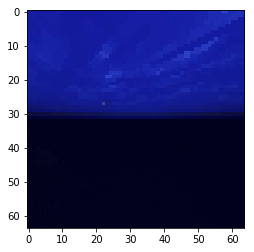

In [78]:
def train_model(target_model, q_model, n_epochs=100, tau = 50):
    for epoch in range(n_epochs):
        print(epoch)
        simulate(target_model, q_model, epoch, tau)
        if epoch > 20:
            training_step(target_model, q_model, epoch, tau)
        if epoch % tau == 0:
            target_model.set_weights(q_model.get_weights())
        
train_model(target_model, q_model)

(1, 8, 8, 50)


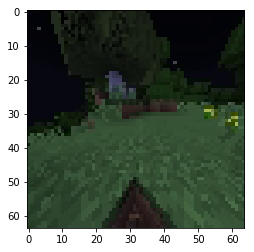

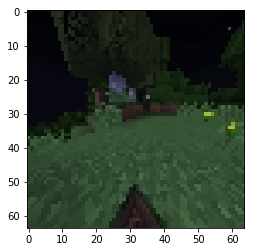

Guessed rewards:  [[1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.]]
Best predicted action:  7
Actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


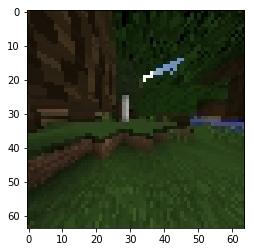

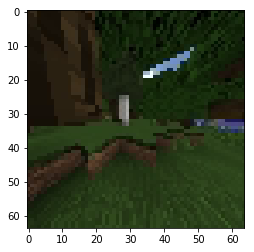

Guessed rewards:  [[0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.]]
Best predicted action:  5
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


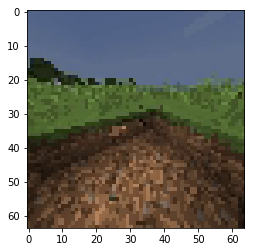

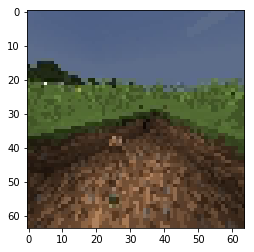

Guessed rewards:  [[1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0.]]
Target rewards:  [[1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0.]]
Best predicted action:  7
Actions:  ['0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


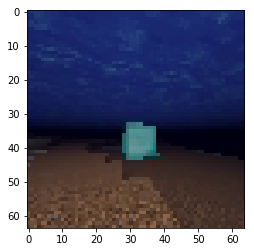

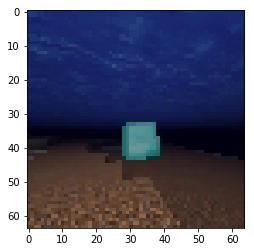

Guessed rewards:  [[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]]
Target rewards:  [[0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.]]
Best predicted action:  5
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


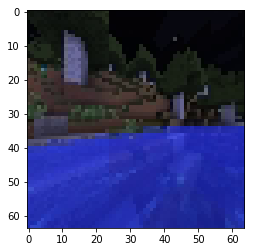

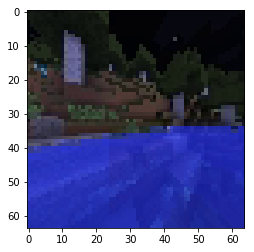

Guessed rewards:  [[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]]
Target rewards:  [[0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.]]
Best predicted action:  5
Actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


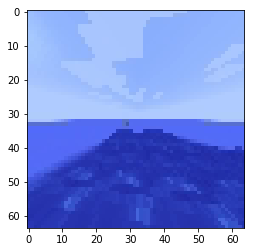

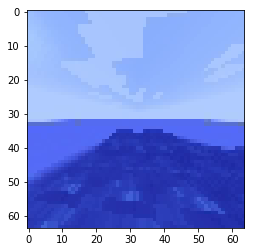

Guessed rewards:  [[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]]
Target rewards:  [[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.]]
Best predicted action:  3
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


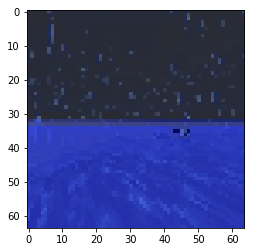

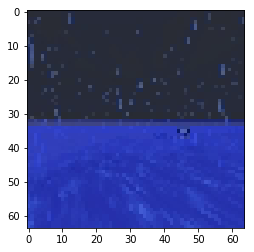

Guessed rewards:  [[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]]
Target rewards:  [[0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.]]
Best predicted action:  5
Actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


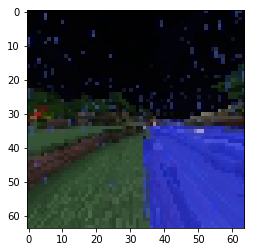

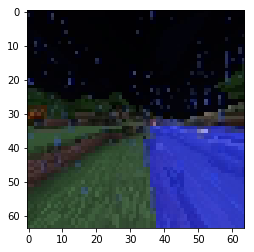

Guessed rewards:  [[0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.]]
Best predicted action:  5
Actions:  ['1' '1' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0']
(1, 8, 8, 50)


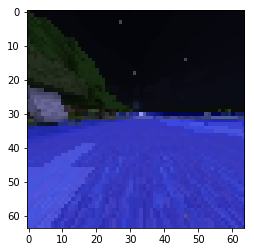

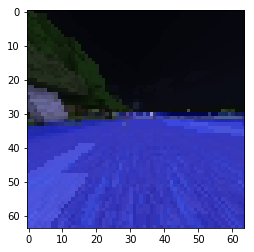

Guessed rewards:  [[0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]]
Target rewards:  [[0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.]]
Best predicted action:  5
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '1']
(1, 8, 8, 50)


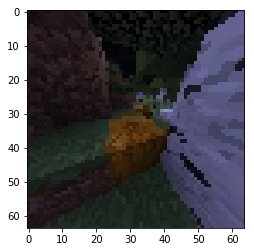

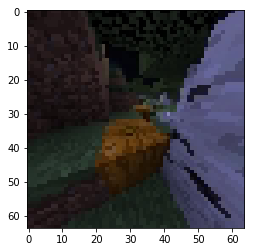

Guessed rewards:  [[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]]
Best predicted action:  7
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '1']


In [79]:
for i in range(10):    
    autoencoder = keras.models.load_model("CNN_enc.h5")
    encoder, decoder = autoencoder.layers
    encoder.trainable = False
    
    video, actions, compass_angle, rewards = generate_random_video(path)

    batch = np.random.randint(video.shape[0])
    frames = encoder.predict(np.array(video[batch]).reshape(1, 64, 64, 3))
    next_frames = encoder.predict(np.array(video[batch+1]).reshape(1, 64, 64, 3))
    
    print(frames.shape)

    plt.imshow(video[batch])
    plt.show()
    
    plt.imshow(video[batch+1])
    plt.show()

    actions = np.array(actions[batch]) 
    
    print("Guessed rewards: ", np.round(q_model(frames)))
    print("Target rewards: ", np.round(target_model(next_frames)))
    print("Best predicted action: ", np.argmax(q_model(frames)))
    print("Actions: ", actions)

In [397]:
target_model.save("target_lstm.h5")
q_model.save("q_lstm.h5")